In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import random
import time
import gym
import numpy as np

import sys
import os
from munch import Munch
import yaml

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

from PIL import Image
import os
import pandas as pd


from IPython import display
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math

from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

from PIL import Image


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


In [3]:
df = pd.read_csv('ema.csv', sep=',')
df = df.sort_values(['subid', 'dttm_obs'])[['dttm_obs', 'subid', 'ema_1', 'ema_2', 'ema_3', 'ema_4', \
                                            'ema_5', 'ema_6', 'ema_7', 'ema_8', 'ema_9', 'ema_10']]

# Handling NA: drop the entire row if 4th entry is NA 
# For morning-only survey, set dummy=1 if survey reported, otherwise dummy=0
df = df.fillna(-6.0)
df = df[df['ema_4'] > -1]
df['ema_dummy'] = (df['ema_8'] > -1)
df.loc[df['ema_8'] < 0, ['ema_8', 'ema_9', 'ema_10']] = 0

# Encoding: 'Yes/No -> 0/1'
df = df.replace('No',0)
df = df.replace('Yes',1)

# Date-time encoding -- in hour unit 
df['date'] = (pd.to_datetime(df['dttm_obs']).astype('int64') // (10**9)) / 3600
df2 = df[['subid', 'ema_1', 'ema_2', 'ema_3', 'ema_4', \
            'ema_5', 'ema_6', 'ema_7', 'ema_8', 'ema_9', 'ema_10', 'ema_dummy', 'date']]


time_df = pd.read_csv('labels_1day.csv', sep=',')
time_df = time_df.sort_values(['subid', 'dttm_label']) 
time_df['date'] = (pd.to_datetime(time_df['dttm_label']).astype('int64') // (10**9)) / 3600
time_df = time_df.replace('no',0)
time_df = time_df.replace('yes',1)

time_df = time_df[['subid', 'lapse', 'date']]

In [4]:
from env import calculate_feature

def input_data(org_data, time_label):
    j = [0,0,0,0,0]
    fj = 0
    window = [12, 24, 48, 72, 168]
    
    dataset = []
    tq, ts = 0, 1
    
    # offset starting date-time to 0 
    offset_time = org_data[0,-1] + 0.0
    org_data[:,-1] -= offset_time
    time_label[:,-1] -= offset_time
    
    while( tq < time_label.shape[0] and ts < org_data.shape[0] ):
        time = time_label[tq,-1]        
        for k in range(5):
            while( j[k] < ts-1 and org_data[j[k], -1] < time - window[k] ):
                j[k] = j[k] + 1

        X2 = calculate_feature(org_data[:ts, 1:-1], org_data[ts-1, 1:-1], j)
        if(ts == org_data.shape[0] or (tq < time_label.shape[0] and time_label[tq, -1] < org_data[ts, -1])):
            y = 1 if( time_label[tq,1] > 0 ) else 0
            dataset.append({'type':'query', 'out': y, 'time': time_label[tq,-1], 'obs': org_data[ts,1:-1]+0.0, 'fullX': X2 })
            while(tq < time_label.shape[0] and time_label[tq,-1] < org_data[ts,-1] ):
                tq += 1
        else:
            y = 1 if( tq < time_label.shape[0] and time_label[tq,1] > 0 ) else 0
            dataset.append({'type':'survey', 'obs': org_data[ts, 1:-1]+0.0, 'time': org_data[ts,-1], 'out':y, 'fullX': X2})
            ts += 1

    return dataset


In [5]:
raw_data = df2.values.astype(np.float32)
time_raw_data = time_df.values.astype(np.float32)

import time
st = time.time()
env_list, subid_list = [], []
print_list = []
for subid in range(270):
    # print(subid)
    sub_data = raw_data[raw_data[:,0]==(subid+1)]
    time_label = time_raw_data[time_raw_data[:,0]==(subid+1)]
    if( len(sub_data) == 0 or len(time_label) == 0 ):
        continue
          
    subid_list.append(subid)
    print_list.append(subid+1)
    env_list.append(input_data(sub_data, time_label))

print(print_list, time.time() - st, env_list[0][0]['fullX'].shape)

[1, 2, 3, 5, 6, 7, 9, 10, 11, 15, 16, 18, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 37, 38, 39, 40, 42, 43, 44, 47, 48, 51, 52, 53, 54, 56, 58, 59, 63, 64, 65, 66, 74, 76, 77, 78, 79, 80, 81, 82, 84, 85, 86, 88, 90, 92, 93, 94, 97, 98, 99, 100, 103, 109, 110, 116, 117, 118, 119, 121, 128, 130, 131, 134, 135, 136, 137, 138, 139, 143, 149, 150, 156, 158, 161, 162, 163, 166, 167, 169, 171, 172, 175, 178, 179, 180, 181, 183, 185, 187, 188, 189, 190, 191, 192, 193, 196, 197, 200, 201, 203, 205, 207, 208, 209, 211, 212, 213, 214, 215, 218, 221, 222, 223, 224, 225, 230, 231, 232, 234, 236, 238, 240, 241, 242, 243, 245, 248, 252, 255, 259, 262, 263, 264, 265, 268, 270] 43.7073700428009 (143,)


# XGBoost Comparison

In [6]:
import xgboost as xgb
from sklearn import metrics
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def input_xgboost_data(org_data, time_label):
    j = [0,0,0,0,0]
    fj = 0
    window = [12, 24, 48, 72, 168]
    
    dataset = []
    tq = ts = 0

    while( ts < org_data.shape[0] ):
        while(tq < time_label.shape[0] and time_label[tq,-1] < org_data[ts,-1] ):
            tq += 1
            
        if( tq >= time_label.shape[0] ):
            break
            
        time = time_label[tq,-1]
        while( ts < org_data.shape[0] and org_data[ts,-1] <= time ):
            ts += 1
        
        for k in range(5):
            while( j[k] < ts-1 and org_data[j[k], -1] < time - window[k] ):
                j[k] = j[k] + 1
                              
        X = calculate_feature(org_data[:ts, 1:-1], org_data[ts-1, 1:-1], j)
        y = 1 if ( time_label[tq,1] > 0 ) else 0        
        dataset.append({'in':X, 'out':y})

    return dataset


def xgboost_main(train_index, test_index):
    trainset = []
    for m in train_index:
        subid = subid_list[m] + 1
        sub_data = raw_data[raw_data[:,0] == subid] 
        time_label = time_raw_data[time_raw_data[:,0]==subid]                
        trainset.extend(input_xgboost_data(sub_data, time_label))

    train_loader = torch.utils.data.DataLoader(trainset, batch_size=500000, shuffle=True, drop_last=False)

    testset = []
    for m in test_index:
        subid = subid_list[m] + 1
        sub_data = raw_data[raw_data[:,0] == subid]     
        time_label = time_raw_data[time_raw_data[:,0]==subid]                
        testset.extend(input_xgboost_data(sub_data, time_label))

    test_loader = torch.utils.data.DataLoader(testset, batch_size=60000, shuffle=False, drop_last=False)

    
    # XG Boost Train
    data_iter = iter(train_loader)
    train_data = next(data_iter)
    X = train_data['in']
    y = train_data['out']

    test_iter = iter(test_loader)
    test_data = next(test_iter)

    # Create regression matrices
    dtrain_reg = xgb.DMatrix(X, y)

    X_test = test_data['in']
    y_test = test_data['out']
    dtest_reg = xgb.DMatrix(X_test, y_test)

    params = {"objective": "reg:squarederror", "tree_method": "hist", "device": "cuda", "max_depth": 5}

    print(X.shape, X_test.shape)
    
    n = 10
    xgmodel = xgb.train(
       params=params,
       dtrain=dtrain_reg,
       num_boost_round=n,
    )

    preds = xgmodel.predict(dtest_reg)
    print(len(y_test[y_test>0]), len(preds[preds>0.1]), len(preds))
    xgauc = roc_auc_score(y_test, preds)
    print('XgBoost: AUC = %.2f' % xgauc)  #1
         
    return xgauc


# Environment Configuration

In [7]:
from env import Env, VecEnv

# parallel env runs
num_process = 31

# action encoding: 
# 0 - no survey or predict
# 1 - yes survey or predict
action_dim = 1
action_max = 2

# feature encoding: mean of survey items
feature_dim = 7

# y encoding
# 0 - no lapse within 24hr
# 1 - yes lapse within 24hr
state_dim, embed_dim, y_max = 143, 128, 2

# Reinforcement Learning

In [8]:

# get trajectory sample batch
def get_sample(traj, model, device):
    action = traj['action'].reshape(-1, 1).to(device)  # [B, n]
    reward = traj['reward'].reshape(-1, 1).to(device)  # [B, n]    
    s1 = model(traj['state'].to(device)).detach()
    s2 = model(traj['nstate'].to(device)).detach()
    t1 = traj['type'].to(int).to(device)
    t2 = traj['ntype'].to(int).to(device)
    done = traj['done'].reshape(-1, 1).to(device)

    return t1, s1, action, reward, t2, s2, done

# train function (without extra features)
def train(venv, model, agent, feature_optimizer, predict_buffer, max_iter = 50, freq=1, burn_in = -1, 
          ca = 0.025, cb = 0.2, full_random = False):
    ce_criterion = torch.nn.CrossEntropyLoss(reduction='none')
    mse_criterion = torch.nn.MSELoss(reduction='none')
    LReLU = torch.nn.LeakyReLU(0.1)
    ReLU = torch.nn.ReLU()
    buffer = ReplayBuffer()
    n_process = 31
    cumr = []
    
    for episode in range(max_iter):
        if( (episode + 1) % 20 == 0 and episode > burn_in ):
            #mid_full_auc = test(venv, model, agent, 'full', freq=freq)
            mid_auc = test(venv, model, agent)            
            #print(mid_full_auc, mid_auc)            
            cumr = cumr[len(cumr)//2:]
            
        X, info = venv.reset(mode='train')
        # print(n_process, num_process)

        # initialize buffers / debug variables
        sample_traj = []
        predict_samples = []
        
        measured_ta = []
        measured_tr = []
        types = torch.zeros(n_process).to(int)
        
        # generate trajectories
        for t in range(1000):
            PX = X
            embed = model(PX.to(device))
            p = random.random()
            
            # sample at least once a week
            if( t < 10 or p < 0.05 ):
                actions = torch.zeros(n_process, action_dim).to(int) + 1
            elif( episode < burn_in ):
                actions = torch.zeros(n_process, action_dim).to(int) + (p < 1. / freq) 
            else:
                actions, _, _ = agent.select_action(embed, types.to(device))
                actions = actions.detach().cpu()
            
            X, X2, rewards, dones, infos = venv.step(actions)
            all_done = True
            
            predict_ys, predict_ft = model.predict_forward(embed)
            predict_ft = predict_ft.detach().cpu()
            predict_ys = nn.Softmax(dim=-1)(predict_ys).reshape(-1, y_max).detach().cpu()
            true_ys = nn.Softmax(dim=-1)(model.predict_forward(model(X2.to(device)))[0]).reshape(-1,y_max).detach().cpu()
            
            for i in range(n_process):
                if( infos[i] == -1 ):
                    continue
                
                all_done = False
                if (infos[i]['type'] == 'survey'):
                    # if too much prediction error, then...
                    var_sample = 0.1 * (predict_ft[i][0]-infos[i]['feature'][0])**2 \
                                        + 0.01 * ((predict_ft[i][1:]-infos[i]['feature'][1:])**2).mean()

                    if( actions[i] == 1 ):
                        # measure encouraing rewards based on variances (larger variance, more desired to measure)
                        rewards[i] += var_sample
                        
                    if( i == 11 and (t+1)%50 == 0 ):
                        print( var_sample * 10, actions[i], rewards[i] )
                    
                    # predict if it is something you would've have seen if you measured
                    predict_samples.append({'type':'survey', 'in': PX[i], 'out': infos[i]['lapse'], 'feature': infos[i]['feature']})    
                
                else:
                    y, cy = infos[i]['lapse'], predict_ys[i][1] 
                    # rewards[i] -= 10 * (y * LReLU(5*(dy - cy))**2 + (1 - y) * LReLU(5*(cy - dy))**2)
                    # rewards[i] -= 50 * (cy - dy)**2
                    rewards[i] += 2 * ( y * np.log(cy + 1e-4) + (1-y) * np.log((1-cy) + 1e-4) )

                    # rewards[i] -= 10 * (y * ReLU(5*(cb - cy))**2 + (1 - y) * min(ReLU(5*(cy - ca))**2, 0.2))
                    ## rewards[i] -= y * 25 * LReLU(cb - cy) + (1 - y) * 5 * LReLU(cy - ca)                    
                    predict_samples.append({'type':'query', 'in': PX[i], 'out': infos[i]['lapse'], 'feature': infos[i]['feature']})
                    
                ptype = types[i]
                types[i] = 1 if( infos[i]['next_type'] == 'query' ) else 0
                # wait until prediction network becomes reliable
                if( episode > burn_in ):
                    sample_traj.append({'type': ptype, 'state': PX[i], 'action': actions[i], 'reward': rewards[i], \
                                'ntype': types[i], 'nstate': X[i], 'done': dones[i]})
            
            if( episode > burn_in ):
                cumr.extend(rewards)
            
            if( all_done ): 
                break
                
        predict_buffer.add_episodes(predict_samples)
        buffer.add_episodes(sample_traj)
        
        if( episode < burn_in ):
            continue
            
        #######################################################
        # Training Phase        
        #######################################################
        # 1. train prediction first
        feat_train_loaders = predict_buffer.get_loader()
        feat_data_iter = iter(feat_train_loaders)
        train_iters = 2000 if (episode == burn_in) else 20
        for j in range(0, train_iters):
            try:
                traj = next(feat_data_iter)

                refs = traj['in'].to(device)
                embeds = model(refs)
                out_ys, out_features = model.predict_forward(embeds)
                ys = traj['out'].reshape(-1).to(device)
                features = traj['feature'].reshape(-1, feature_dim).to(device)
                tps = np.array(traj['type'])
                wf = (tps=='survey')
                wy = (tps=='query')
                
                predict_loss = ce_criterion(out_ys[wy], ys[wy]).mean()
                predict_loss += 0.1 * mse_criterion(out_features[wf], features[wf]).mean()
                predict_loss.backward()
                
                feature_optimizer.step()
                feature_optimizer.zero_grad()

            except StopIteration:
                feat_train_loaders = predict_buffer.get_loader()
                feat_data_iter = iter(feat_train_loaders)
                continue
        
        if( episode < burn_in + 3 ):
            continue
        print('episode: ', episode, 'loss: ', predict_loss, 'average reward: ', np.mean(cumr))
            
        # 2. train SAC
        train_loaders = buffer.get_loader(batch_size=4096)
        data_iter = iter(train_loaders)

        for j in range(0, 500):
            try:
                traj = next(data_iter)
                batch = get_sample(traj, model, device)

            except StopIteration:
                train_loaders = buffer.get_loader(batch_size=4096)
                data_iter = iter(train_loaders)
                continue

            agent.update(batch)

        agent.update_target()


# Test Reinforcement Learning Result

In [9]:

def test(venv, model, agent, mode='policy', freq=1, run_id=0, kfold_id=0, penalty=-1., verbose=True):
    scatter = []
    num_process = len(venv.test_ids)
    
    cnt, n_measure, n_hit = [0 for i in range(num_process)], [0 for i in range(num_process)], [0 for i in range(num_process)]
    cnt2 = [0 for i in range(num_process)]
    cnt3 = [0 for i in range(num_process)]

    y, outy = [], []

    X, info = venv.reset(mode='test')
    types = torch.zeros(num_process).to(int)
    for t in range(1000):
        PX = X
        embeds = model(PX.to(device))
        p = random.random()
        if( t < 10 or p < 0.02 ):
            actions = torch.zeros(num_process, action_dim).to(int) + 1
        elif( mode == 'full' ):
            actions = torch.zeros(num_process, action_dim).to(int) + (p < 1./freq)
        else:
            actions, _, _ = agent.select_action(embeds, types.to(device), explore=False)
            
        X, _,_,_, infos = venv.step(actions)
        predict_ys, _ = model.predict_forward(embeds)
        predict_ys = predict_ys.detach().cpu()
   
        # add transition data to dataset
        all_done = True
        for i in range(num_process):
            if( infos[i] == -1 ):
                continue

            all_done = False
            if (infos[i]['type'] == 'query'):
                check_y = nn.Softmax(dim=-1)(predict_ys[i])                
                y.append(infos[i]['lapse'])
                outy.append(check_y[1])
                
                if( infos[i]['lapse'] > 0 ):
                    n_hit[i] += 1 
                    if(check_y[1] < 0.05):
                        cnt2[i] += 1
                    if(check_y[1] < 0.09):
                        cnt3[i] += 1                        
            else:
                cnt[i] += 1
                n_measure[i] += 1 if( actions[i] % 2 == 1 ) else 0
                                    
            types[i] = 1 if( infos[i]['next_type'] == 'query' ) else 0

        if( all_done ): 
            break

    for i in range(num_process):
        scatter.append([n_measure[i]/cnt[i], n_hit[i]/cnt[i]])
        if( verbose ):
            print(venv.test_ids[i], ':', n_measure[i], n_hit[i], cnt[i], cnt2[i], cnt3[i])
    
    
#     path = os.path.join("./results", f"run_{run_id}_kfold_{kfold_id}_penalty_{penalty}.pt")
#     things_to_save = {
#         'test_ids': venv.test_ids,
#         'model_state_dict': model.state_dict(),
#         'agent_state_dict': agent.save_dict()
#     }
#     torch.save(things_to_save, path)
    
    scatter = np.array(scatter)
#     import matplotlib.pyplot as plt
#     plt.figure(figsize=(4, 3))  

#     plt.scatter(scatter[:,1], scatter[:,0])
#     plt.xlabel("Average Lapse Count")
#     plt.ylabel("Survey Ratio")
#     plt.show()

    outy0 = np.array(outy)[np.array(y)==0]
    outy1 = np.array(outy)[np.array(y)==1]   
    
    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))     
    
    axes[0].hist(outy0, bins=50, alpha=0.5, label='Class 0')
    axes[1].hist(outy1, bins=50, alpha=0.5, label='Class 1')
#     axes[0].xlabel('Score P(y=1)')
#     axes[1].xlabel('Score P(y=1)')
#     axes[0].ylabel('Frequency')
#     axes[1].ylabel('Frequency')
    
    axes[2].scatter(scatter[:,1], scatter[:,0])
#     axes[2].xlabel("Average Lapse Count")
#     axes[2].ylabel("Survey Ratio")
    
    plt.show()

    print('Average Survey Ratio:', np.mean(scatter[:,0]))

    import xgboost as xgb
    from sklearn import metrics
    from sklearn.metrics import roc_auc_score
    import matplotlib.pyplot as plt
    from sklearn.model_selection import train_test_split

    fgauc = roc_auc_score(y, outy)
    print('AUC = %.2f' % fgauc)  #1
    return fgauc
    
    

In [10]:
import random
from SACD import init_SACD_agent
from model import build_model
from buffer import ReplayBuffer
  
import torch.nn.functional as F
import time
import copy

# weight-decay params: {1e-3, 5e-4, 1e-4, 5e-5, 1e-5}

def k_fold_test(k=5, run_id=0):
    shuffled_index = list(range(151))
    random.shuffle(shuffled_index)

    AUC_dict={}
    AUC_dict['xg'] = []
    for freq in [1,5,10]:
        AUC_dict[freq] = []
        
    for i in range(k):
        st,et = i*151//k, (i+1)*151//k

        test_index = shuffled_index[st:et]
        train_index = list(set(range(151)) - set(test_index))
        xgauc = xgboost_main(train_index, test_index)
        AUC_dict['xg'].append(xgauc)
        
        venv = VecEnv(env_list, train_index, test_index, num_process=num_process, state_dim=state_dim)
        
        model = build_model(embed_dim, state_dim, action_dim, feature_dim, action_max, \
                            y_max, model_family='gpt2').to(device)
        agent = init_SACD_agent(state_dim, action_dim, action_max, device, embed_dim=embed_dim, \
                                weight_decay=5e-3, lr_actor=2e-5, lr_critic=5e-5, entropy_regularizer=0.03)
        feature_optimizer = torch.optim.Adam([{'params': model.parameters(), 'lr': 1e-5, 'weight_decay':5e-3}])
        predict_buffer = ReplayBuffer()

        # init predictor part
        for freq in [1,5,20,2,50]:
            train(venv, model, agent, feature_optimizer, predict_buffer, freq=freq, max_iter=10, burn_in=9)
        
        for freq in [1,3,15]:            
            test(venv, model, agent, 'full', freq=freq)

        venv.set_probe_penalty(0.1)
        train(venv, model, agent, feature_optimizer, predict_buffer, freq=15, max_iter=100)        
        # Test full observation-prediction
        fcauc = test(venv, model, agent, run_id=run_id, kfold_id=i, penalty=-1, verbose=True)
        fcauc = test(venv, model, agent, 'full', run_id=run_id, kfold_id=i, penalty=-1, verbose=True)
        AUC_dict[1].append(fcauc)

#         for freq in [5, 10]:
#             print('-----------------------------------------------')
#             penalty = freq * 0.05
#             venv.set_probe_penalty(penalty)
#             train(venv, model, agent, feature_optimizer, predict_buffer, max_iter=50, burn_in=10, freq=freq)

#             # fcauc = test(venv, model, agent, 'full', run_id=run_id, kfold_id=i, penalty=-1)
#             fcauc = test(venv, model, agent, freq=freq, run_id=run_id, kfold_id=i, penalty=penalty, verbose=True)
#             AUC_dict[freq].append(fcauc)
            
        print('=================================================')
        
    print(AUC_dict)
    return AUC_dict

torch.Size([29750, 143]) torch.Size([7466, 143])
947 2087 7466
XgBoost: AUC = 0.90
Device set to : cuda:0
tensor(2.4329) tensor([1]) tensor(0.2433)
tensor(3.5554) tensor([1]) tensor(0.3555)
tensor(2.1590) tensor([1]) tensor(0.2159)
tensor(7.8616) tensor([1]) tensor(0.7862)
tensor(6.1656) tensor([1]) tensor(0.6166)
tensor(4.3795) tensor([1]) tensor(0.4379)
tensor(3.5588) tensor([1]) tensor(0.3559)
tensor(2.5181) tensor([1]) tensor(0.2518)
tensor(3.0713) tensor([1]) tensor(0.3071)
tensor(3.5185) tensor([1]) tensor(0.3518)
tensor(1.3205) tensor([1]) tensor(0.1320)
tensor(3.5150) tensor([1]) tensor(0.3515)
tensor(3.0557) tensor([1]) tensor(0.3056)
tensor(7.4097) tensor([1]) tensor(0.7410)
tensor(3.4732) tensor([1]) tensor(0.3473)
tensor(2.3677) tensor([1]) tensor(0.2368)
tensor(4.1357) tensor([1]) tensor(0.4136)
tensor(5.3236) tensor([1]) tensor(0.5324)
tensor(7.1407) tensor([1]) tensor(0.7141)
tensor(5.1833) tensor([1]) tensor(0.5183)
tensor(6.5750) tensor([1]) tensor(0.6575)
tensor(0.732

tensor(0.3426) tensor([0]) tensor(0.)
tensor(4.9671) tensor([0]) tensor(0.)
tensor(7.2432) tensor([0]) tensor(0.)
tensor(1.5828) tensor([1]) tensor(0.1583)
tensor(4.4691) tensor([0]) tensor(0.)
tensor(2.3669) tensor([0]) tensor(0.)
tensor(0.3365) tensor([0]) tensor(0.)
tensor(0.8396) tensor([1]) tensor(0.0840)
tensor(1.1923) tensor([0]) tensor(0.)
tensor(0.3141) tensor([0]) tensor(0.)
tensor(0.5211) tensor([0]) tensor(0.)
tensor(0.6250) tensor([0]) tensor(0.)
tensor(2.0660) tensor([0]) tensor(0.)
tensor(1.0305) tensor([0]) tensor(0.)
tensor(2.0128) tensor([0]) tensor(0.)
tensor(0.6236) tensor([0]) tensor(0.)
tensor(1.6128) tensor([0]) tensor(0.)
tensor(0.5400) tensor([0]) tensor(0.)
tensor(0.9336) tensor([0]) tensor(0.)
tensor(1.0434) tensor([0]) tensor(0.)
tensor(0.4569) tensor([0]) tensor(0.)
tensor(0.6912) tensor([0]) tensor(0.)
tensor(0.1354) tensor([0]) tensor(0.)
tensor(0.5656) tensor([0]) tensor(0.)
tensor(0.4959) tensor([0]) tensor(0.)
tensor(0.8722) tensor([0]) tensor(0.)
tens

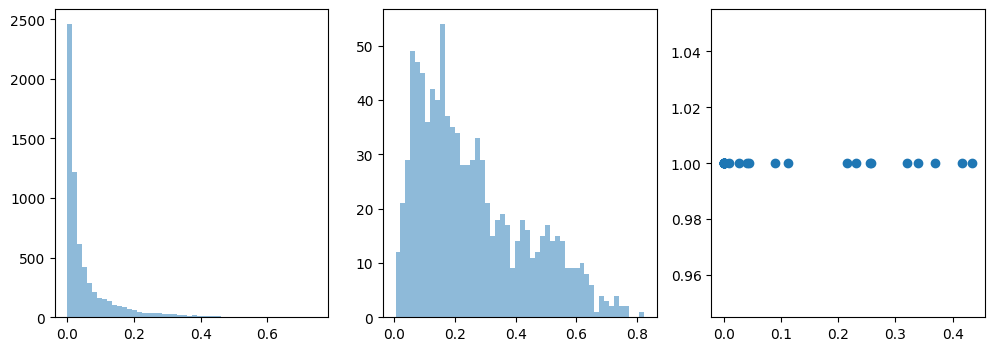

Average Survey Ratio: 1.0
AUC = 0.89
83 : 108 0 323 0 0
115 : 67 0 169 0 0
140 : 57 0 168 0 0
38 : 127 120 354 4 14
40 : 113 136 313 5 9
17 : 112 8 295 0 3
21 : 121 0 325 0 0
43 : 103 0 277 0 0
2 : 126 38 337 12 23
87 : 111 13 324 0 4
85 : 131 16 367 0 0
5 : 120 72 335 4 10
101 : 94 0 264 0 0
46 : 104 0 284 0 0
34 : 128 135 324 2 6
94 : 121 0 331 0 0
71 : 143 33 370 3 14
118 : 65 0 199 0 0
123 : 116 0 319 0 0
114 : 119 0 334 0 0
91 : 134 87 337 10 18
57 : 122 0 337 0 0
16 : 120 88 345 3 12
124 : 52 42 131 1 11
98 : 122 0 329 0 0
53 : 44 1 113 1 1
30 : 124 78 337 2 15
39 : 75 76 206 0 7
22 : 68 0 179 0 0
106 : 94 0 267 0 0


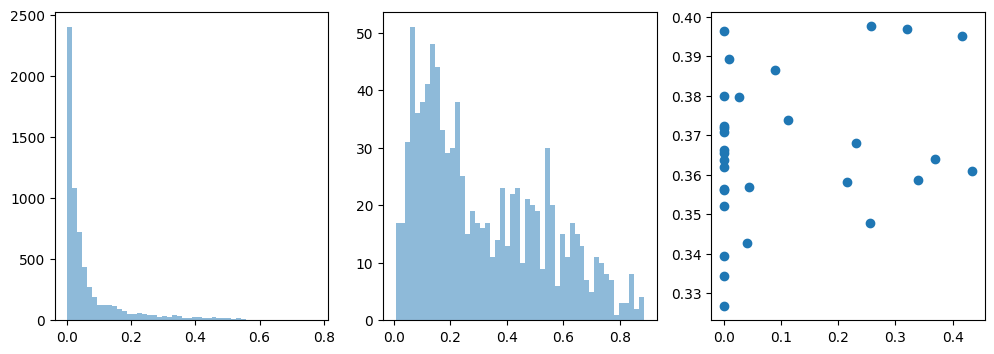

Average Survey Ratio: 0.36632816920964706
AUC = 0.89
83 : 26 0 323 0 0
115 : 21 0 169 0 0
140 : 23 0 168 0 0
38 : 30 120 354 0 7
40 : 29 136 313 14 14
17 : 23 8 295 0 4
21 : 28 0 325 0 0
43 : 24 0 277 0 0
2 : 29 38 337 13 29
87 : 30 13 324 0 5
85 : 30 16 367 0 0
5 : 26 72 335 4 4
101 : 21 0 264 0 0
46 : 23 0 284 0 0
34 : 28 135 324 0 5
94 : 30 0 331 0 0
71 : 31 33 370 25 29
118 : 21 0 199 0 0
123 : 23 0 319 0 0
114 : 27 0 334 0 0
91 : 29 87 337 1 8
57 : 27 0 337 0 0
16 : 30 88 345 2 21
124 : 13 42 131 16 21
98 : 27 0 329 0 0
53 : 14 1 113 1 1
30 : 27 78 337 6 14
39 : 22 76 206 0 5
22 : 22 0 179 0 0
106 : 23 0 267 0 0


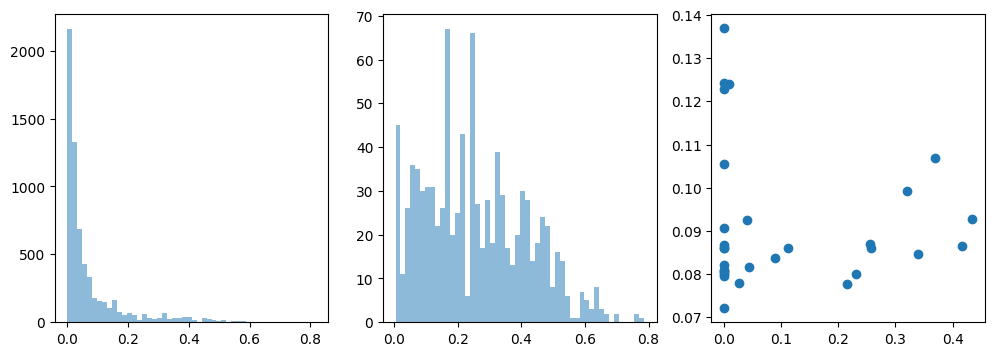

Average Survey Ratio: 0.09139820276252696
AUC = 0.86
tensor(0.6501) tensor([1]) tensor(-0.0350)
tensor(0.2781) tensor([1]) tensor(-0.0722)
tensor(0.2616) tensor([0]) tensor(0.)
tensor(0.7051) tensor([1]) tensor(-0.0295)
tensor(0.5613) tensor([0]) tensor(0.)
tensor(0.5373) tensor([1]) tensor(-0.0463)
tensor(1.9404) tensor([0]) tensor(0.)
tensor(2.4269) tensor([1]) tensor(0.1427)
tensor(1.6778) tensor([0]) tensor(0.)
tensor(1.1408) tensor([1]) tensor(0.0141)
tensor(1.1732) tensor([0]) tensor(0.)
tensor(0.9292) tensor([1]) tensor(-0.0071)
tensor(0.3845) tensor([1]) tensor(-0.0616)
episode:  2 loss:  tensor(0.7739, device='cuda:0', grad_fn=<AddBackward0>) average reward:  -0.13451658
tensor(0.4286) tensor([1]) tensor(-0.0571)
tensor(0.2305) tensor([0]) tensor(0.)
tensor(0.4093) tensor([0]) tensor(0.)
episode:  3 loss:  tensor(0.8302, device='cuda:0', grad_fn=<AddBackward0>) average reward:  -0.13537347
tensor(0.3977) tensor([0]) tensor(0.)
tensor(0.0687) tensor([0]) tensor(0.)
tensor(0.175

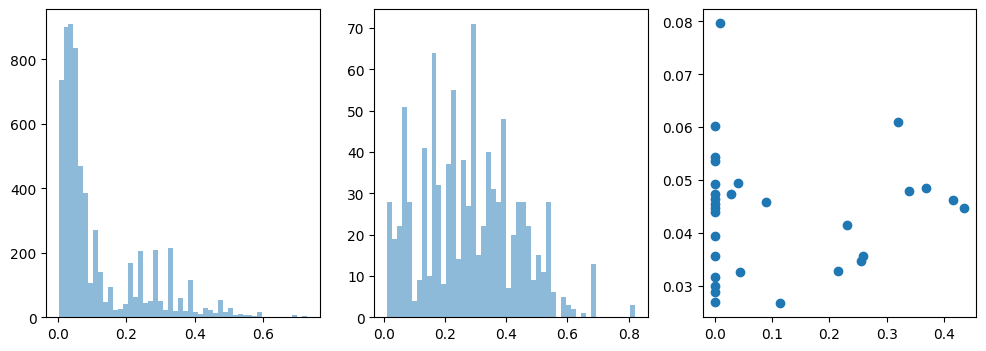

Average Survey Ratio: 0.04377209757421037
AUC = 0.81
tensor(0.3516) tensor([0]) tensor(0.)
tensor(0.8118) tensor([0]) tensor(0.)
tensor(1.2638) tensor([0]) tensor(0.)
tensor(0.2066) tensor([0]) tensor(0.)
tensor(0.0543) tensor([0]) tensor(0.)
tensor(0.2587) tensor([0]) tensor(0.)
episode:  19 loss:  tensor(0.7998, device='cuda:0', grad_fn=<AddBackward0>) average reward:  -0.13257317
tensor(1.2036) tensor([1]) tensor(0.0204)
tensor(0.7194) tensor([0]) tensor(0.)
tensor(0.9579) tensor([1]) tensor(-0.0042)
tensor(1.4317) tensor([1]) tensor(0.0432)
tensor(1.3650) tensor([0]) tensor(0.)
tensor(0.9006) tensor([0]) tensor(0.)
tensor(2.0045) tensor([0]) tensor(0.)
episode:  20 loss:  tensor(0.8245, device='cuda:0', grad_fn=<AddBackward0>) average reward:  -0.1326816
tensor(0.5677) tensor([0]) tensor(0.)
tensor(0.2755) tensor([0]) tensor(0.)
tensor(0.4266) tensor([0]) tensor(0.)
tensor(0.5917) tensor([0]) tensor(0.)
tensor(1.0972) tensor([0]) tensor(0.)
tensor(0.6192) tensor([0]) tensor(0.)
epi

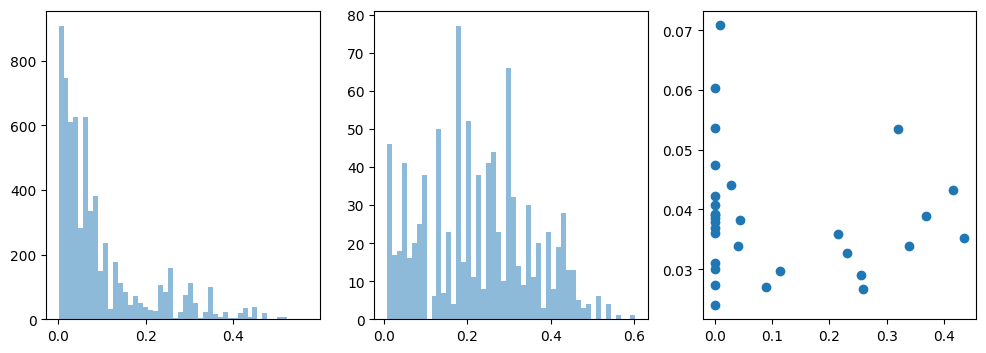

Average Survey Ratio: 0.038554800720017296
AUC = 0.79
tensor(1.1940) tensor([0]) tensor(0.)
tensor(0.9572) tensor([0]) tensor(0.)
episode:  39 loss:  tensor(0.8284, device='cuda:0', grad_fn=<AddBackward0>) average reward:  -0.14415364
tensor(0.6368) tensor([0]) tensor(0.)
tensor(0.9094) tensor([0]) tensor(0.)
tensor(0.5458) tensor([1]) tensor(-0.0454)
tensor(1.1462) tensor([0]) tensor(0.)
tensor(0.5126) tensor([0]) tensor(0.)
tensor(0.6876) tensor([0]) tensor(0.)
episode:  40 loss:  tensor(0.8166, device='cuda:0', grad_fn=<AddBackward0>) average reward:  -0.14365217
tensor(0.4007) tensor([0]) tensor(0.)
tensor(0.2629) tensor([0]) tensor(0.)
tensor(0.1874) tensor([0]) tensor(0.)
tensor(0.5537) tensor([0]) tensor(0.)
tensor(0.3633) tensor([0]) tensor(0.)
tensor(0.4193) tensor([1]) tensor(-0.0581)
episode:  41 loss:  tensor(0.8064, device='cuda:0', grad_fn=<AddBackward0>) average reward:  -0.1424078
tensor(0.4594) tensor([0]) tensor(0.)
tensor(0.4838) tensor([0]) tensor(0.)
tensor(3.2357)

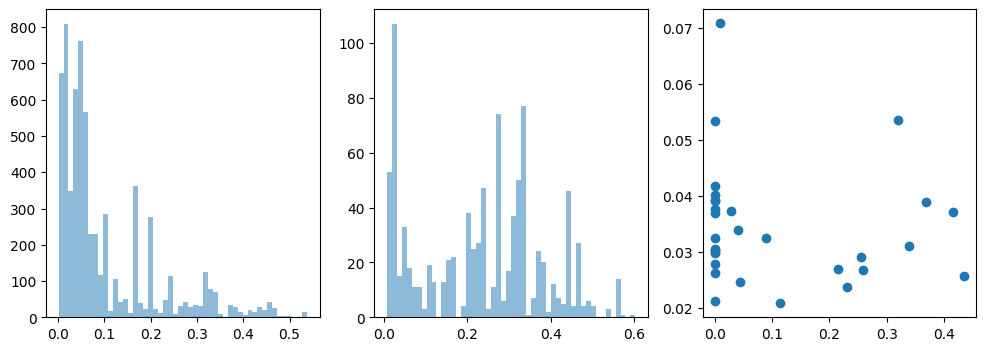

Average Survey Ratio: 0.03426842287879227
AUC = 0.75
tensor(0.6114) tensor([0]) tensor(0.)
tensor(0.7090) tensor([0]) tensor(0.)
tensor(0.5051) tensor([0]) tensor(0.)
tensor(0.2032) tensor([0]) tensor(0.)
tensor(1.0146) tensor([0]) tensor(0.)
tensor(0.3559) tensor([0]) tensor(0.)
tensor(1.4256) tensor([1]) tensor(0.0426)
tensor(0.4443) tensor([0]) tensor(0.)
episode:  59 loss:  tensor(0.8652, device='cuda:0', grad_fn=<AddBackward0>) average reward:  -0.13014875
tensor(2.4902) tensor([0]) tensor(0.)
tensor(1.0058) tensor([0]) tensor(0.)
tensor(1.5355) tensor([0]) tensor(0.)
tensor(3.3670) tensor([0]) tensor(0.)
tensor(2.6603) tensor([0]) tensor(0.)
tensor(3.3812) tensor([1]) tensor(0.2381)
episode:  60 loss:  tensor(0.8541, device='cuda:0', grad_fn=<AddBackward0>) average reward:  -0.12891153
tensor(1.6177) tensor([0]) tensor(0.)
tensor(1.0250) tensor([0]) tensor(0.)
tensor(0.3610) tensor([0]) tensor(0.)
tensor(0.7434) tensor([0]) tensor(0.)
tensor(0.8690) tensor([0]) tensor(0.)
tensor(

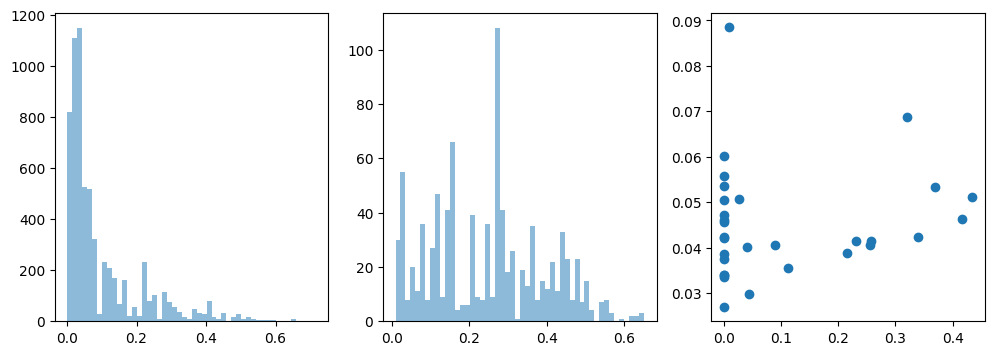

Average Survey Ratio: 0.04529517302317168
AUC = 0.80
tensor(0.6010) tensor([0]) tensor(0.)
tensor(0.4914) tensor([0]) tensor(0.)
episode:  79 loss:  tensor(0.8207, device='cuda:0', grad_fn=<AddBackward0>) average reward:  -0.1279621
tensor(0.7689) tensor([0]) tensor(0.)
tensor(0.5113) tensor([1]) tensor(-0.0489)
tensor(2.2064) tensor([1]) tensor(0.1206)
tensor(1.1620) tensor([0]) tensor(0.)
tensor(0.4384) tensor([0]) tensor(0.)
tensor(0.2100) tensor([0]) tensor(0.)
tensor(0.5211) tensor([0]) tensor(0.)
episode:  80 loss:  tensor(0.8192, device='cuda:0', grad_fn=<AddBackward0>) average reward:  -0.12784748
tensor(0.2901) tensor([1]) tensor(-0.0710)
tensor(4.4034) tensor([0]) tensor(0.)
tensor(0.6455) tensor([0]) tensor(0.)
tensor(1.3649) tensor([0]) tensor(0.)
episode:  81 loss:  tensor(0.8215, device='cuda:0', grad_fn=<AddBackward0>) average reward:  -0.12713969
tensor(0.4745) tensor([0]) tensor(0.)
tensor(1.5040) tensor([0]) tensor(0.)
tensor(2.3055) tensor([0]) tensor(0.)
tensor(2.67

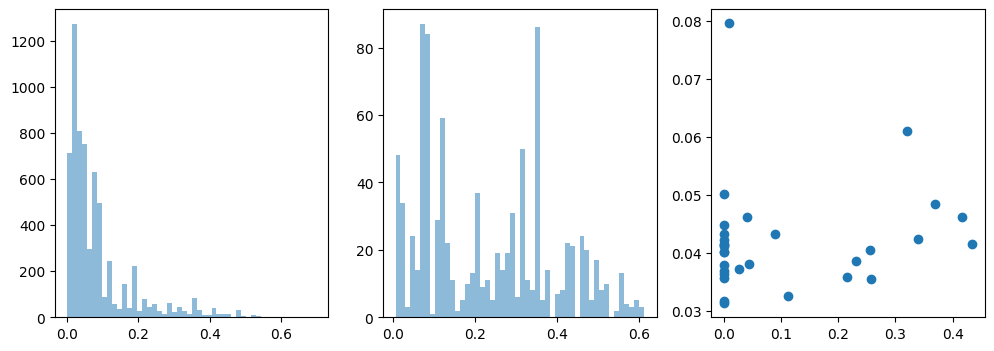

Average Survey Ratio: 0.04210357027025849
AUC = 0.79
tensor(0.8430) tensor([1]) tensor(-0.0157)
tensor(0.3013) tensor([0]) tensor(0.)
tensor(0.3544) tensor([0]) tensor(0.)
tensor(0.2737) tensor([0]) tensor(0.)
tensor(0.4978) tensor([0]) tensor(0.)
tensor(0.3643) tensor([0]) tensor(0.)
tensor(3.1028) tensor([0]) tensor(0.)
episode:  99 loss:  tensor(0.8363, device='cuda:0', grad_fn=<AddBackward0>) average reward:  -0.13381365
83 : 9 0 323 0 0
115 : 7 0 169 0 0
140 : 8 0 168 0 0
38 : 12 120 354 0 42
40 : 10 136 313 7 90
17 : 13 8 295 0 8
21 : 10 0 325 0 0
43 : 10 0 277 0 0
2 : 10 38 337 38 38
87 : 11 13 324 0 0
85 : 13 16 367 0 0
5 : 10 72 335 29 29
101 : 11 0 264 0 0
46 : 11 0 284 0 0
34 : 15 135 324 0 15
94 : 11 0 331 0 0
71 : 12 33 370 5 9
118 : 10 0 199 0 0
123 : 9 0 319 0 0
114 : 10 0 334 0 0
91 : 10 87 337 1 1
57 : 10 0 337 0 0
16 : 12 88 345 27 32
124 : 7 42 131 22 22
98 : 13 0 329 0 0
53 : 7 1 113 1 1
30 : 11 78 337 1 11
39 : 10 76 206 0 0
22 : 8 0 179 0 0
106 : 9 0 267 0 0


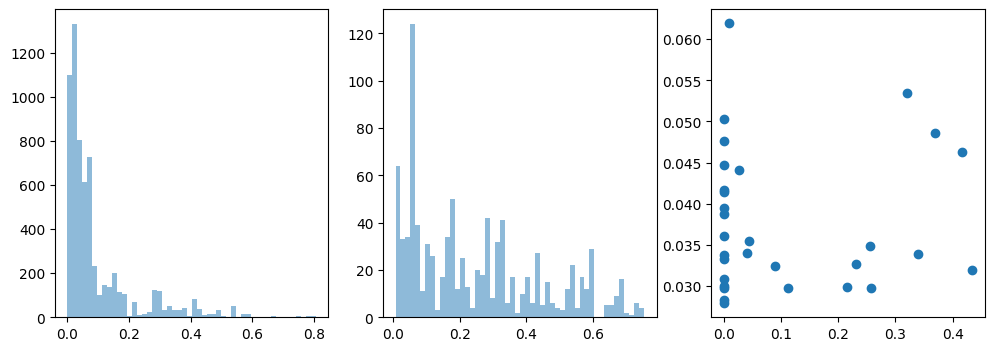

Average Survey Ratio: 0.03773204080714534
AUC = 0.76
83 : 323 0 323 0 0
115 : 169 0 169 0 0
140 : 168 0 168 0 0
38 : 354 120 354 5 19
40 : 313 136 313 6 24
17 : 295 8 295 3 4
21 : 325 0 325 0 0
43 : 277 0 277 0 0
2 : 337 38 337 13 21
87 : 324 13 324 0 0
85 : 367 16 367 0 0
5 : 335 72 335 0 12
101 : 264 0 264 0 0
46 : 284 0 284 0 0
34 : 324 135 324 0 2
94 : 331 0 331 0 0
71 : 370 33 370 1 15
118 : 199 0 199 0 0
123 : 319 0 319 0 0
114 : 334 0 334 0 0
91 : 337 87 337 17 41
57 : 337 0 337 0 0
16 : 345 88 345 0 0
124 : 131 42 131 0 1
98 : 329 0 329 0 0
53 : 113 1 113 1 1
30 : 337 78 337 5 17
39 : 206 76 206 2 6
22 : 179 0 179 0 0
106 : 267 0 267 0 0


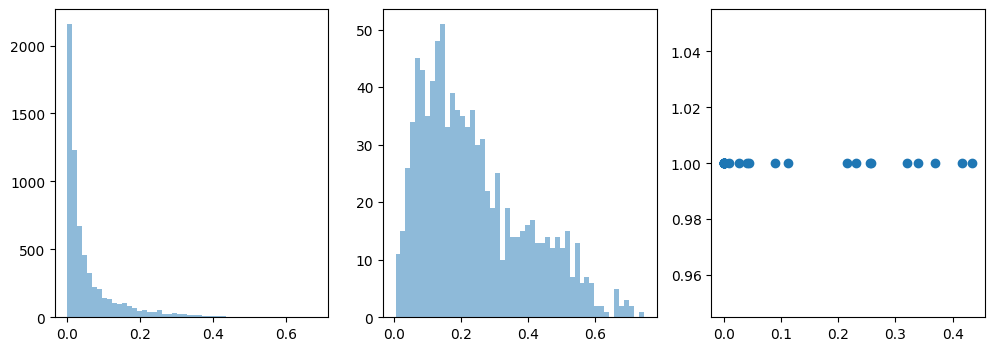

Average Survey Ratio: 1.0
AUC = 0.89
torch.Size([29154, 143]) torch.Size([8062, 143])
532 1853 8062
XgBoost: AUC = 0.89
Device set to : cuda:0
tensor(2.0103) tensor([1]) tensor(0.2010)
tensor(2.0764) tensor([1]) tensor(0.2076)
tensor(2.9227) tensor([1]) tensor(0.2923)
tensor(5.3093) tensor([1]) tensor(0.5309)
tensor(1.6873) tensor([1]) tensor(0.1687)
tensor(3.1917) tensor([1]) tensor(0.3192)
tensor(2.4557) tensor([1]) tensor(0.2456)
tensor(2.5722) tensor([1]) tensor(0.2572)
tensor(2.7034) tensor([1]) tensor(0.2703)
tensor(4.1727) tensor([1]) tensor(0.4173)
tensor(2.8068) tensor([1]) tensor(0.2807)
tensor(2.6178) tensor([1]) tensor(0.2618)
tensor(3.1425) tensor([1]) tensor(0.3142)
tensor(3.3275) tensor([1]) tensor(0.3327)
tensor(3.2422) tensor([1]) tensor(0.3242)
tensor(7.1035) tensor([1]) tensor(0.7103)
tensor(2.5065) tensor([1]) tensor(0.2507)
tensor(2.5383) tensor([1]) tensor(0.2538)
tensor(2.2543) tensor([1]) tensor(0.2254)
tensor(5.2199) tensor([1]) tensor(0.5220)
tensor(3.6126) te

tensor(0.2920) tensor([0]) tensor(0.)
tensor(0.5180) tensor([0]) tensor(0.)
tensor(0.2212) tensor([1]) tensor(0.0221)
tensor(0.1092) tensor([0]) tensor(0.)
tensor(0.0996) tensor([0]) tensor(0.)
tensor(0.7639) tensor([1]) tensor(0.0764)
tensor(1.0519) tensor([1]) tensor(0.1052)
tensor(0.2481) tensor([0]) tensor(0.)
tensor(0.3567) tensor([0]) tensor(0.)
tensor(0.8971) tensor([1]) tensor(0.0897)
tensor(0.7444) tensor([0]) tensor(0.)
tensor(0.4146) tensor([0]) tensor(0.)
tensor(0.4285) tensor([0]) tensor(0.)
tensor(0.2997) tensor([1]) tensor(0.0300)
tensor(0.1492) tensor([0]) tensor(0.)
tensor(0.3317) tensor([1]) tensor(0.0332)
tensor(1.4685) tensor([0]) tensor(0.)
tensor(0.2492) tensor([1]) tensor(0.0249)
tensor(2.2221) tensor([0]) tensor(0.)
tensor(1.3731) tensor([0]) tensor(0.)
tensor(0.6971) tensor([0]) tensor(0.)
tensor(0.3788) tensor([1]) tensor(0.0379)
tensor(0.4604) tensor([1]) tensor(0.0460)
tensor(0.4963) tensor([0]) tensor(0.)
tensor(0.8967) tensor([0]) tensor(0.)
tensor(0.5599)

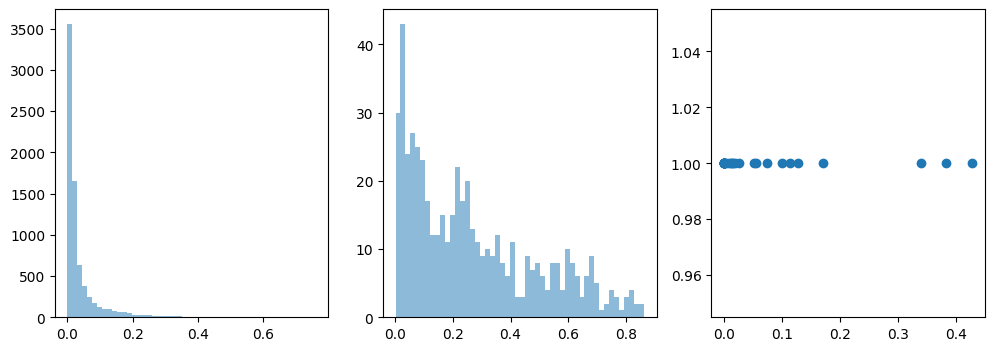

Average Survey Ratio: 1.0
AUC = 0.89
61 : 101 0 303 0 0
89 : 131 0 356 0 0
23 : 102 0 310 0 0
130 : 123 3 356 3 3
121 : 94 3 258 3 3
72 : 113 5 347 5 5
105 : 127 18 342 9 11
73 : 89 82 242 6 8
113 : 93 0 269 0 0
144 : 116 0 332 0 0
67 : 108 48 281 6 21
81 : 116 0 333 0 0
138 : 126 0 335 0 0
29 : 116 0 334 0 0
127 : 114 0 317 0 0
62 : 88 4 263 4 4
56 : 118 128 299 0 0
50 : 121 7 351 7 7
49 : 98 29 253 5 11
65 : 88 7 266 0 5
18 : 119 19 347 14 14
135 : 145 0 407 0 0
76 : 101 102 267 8 11
64 : 100 0 306 0 0
10 : 92 32 252 11 14
24 : 104 29 287 11 23
84 : 84 1 241 1 1
51 : 71 14 189 4 8
110 : 100 0 278 0 0
147 : 111 0 327 0 0


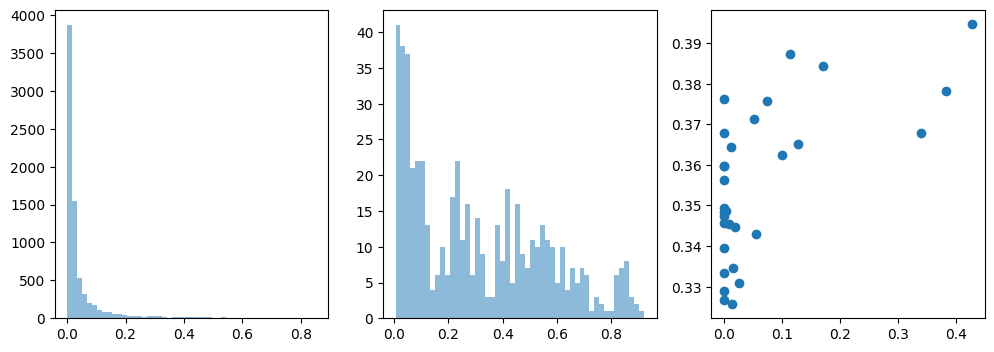

Average Survey Ratio: 0.3554355771271581
AUC = 0.88
61 : 30 0 303 0 0
89 : 36 0 356 0 0
23 : 33 0 310 0 0
130 : 26 3 356 3 3
121 : 24 3 258 3 3
72 : 36 5 347 5 5
105 : 38 18 342 5 16
73 : 28 82 242 15 21
113 : 34 0 269 0 0
144 : 33 0 332 0 0
67 : 31 48 281 4 4
81 : 28 0 333 0 0
138 : 36 0 335 0 0
29 : 36 0 334 0 0
127 : 27 0 317 0 0
62 : 22 4 263 4 4
56 : 33 128 299 0 1
50 : 34 7 351 7 7
49 : 29 29 253 6 6
65 : 25 7 266 0 7
18 : 33 19 347 13 13
135 : 38 0 407 0 0
76 : 30 102 267 8 9
64 : 26 0 306 0 0
10 : 27 32 252 0 11
24 : 29 29 287 11 17
84 : 21 1 241 1 1
51 : 21 14 189 0 5
110 : 36 0 278 0 0
147 : 25 0 327 0 0


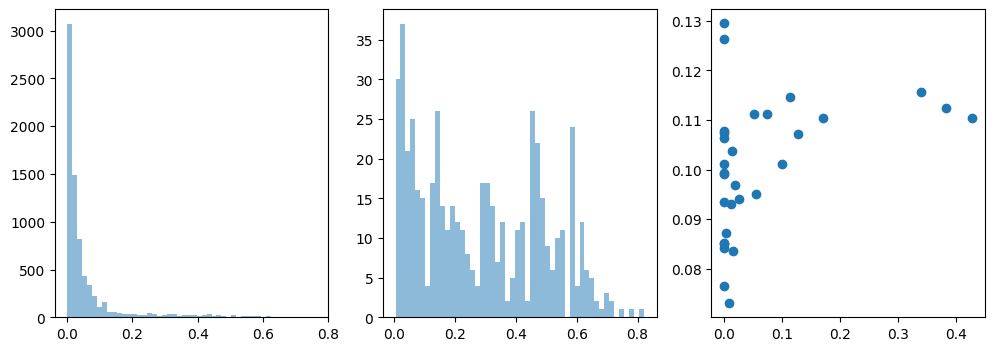

Average Survey Ratio: 0.10071637882915024
AUC = 0.87
tensor(0.6548) tensor([1]) tensor(-0.0345)
tensor(0.3809) tensor([0]) tensor(0.)
tensor(0.7886) tensor([1]) tensor(-0.0211)
tensor(0.8733) tensor([0]) tensor(0.)
tensor(0.1955) tensor([0]) tensor(0.)
tensor(0.5877) tensor([1]) tensor(-0.0412)
tensor(0.9608) tensor([0]) tensor(0.)
tensor(0.4741) tensor([1]) tensor(-0.0526)
tensor(0.3348) tensor([0]) tensor(0.)
tensor(0.7782) tensor([1]) tensor(-0.0222)
tensor(0.8760) tensor([1]) tensor(-0.0124)
tensor(1.0726) tensor([1]) tensor(0.0073)
tensor(0.4170) tensor([1]) tensor(-0.0583)
tensor(0.3284) tensor([0]) tensor(0.)
tensor(1.8376) tensor([0]) tensor(0.)
tensor(0.2506) tensor([1]) tensor(-0.0749)
tensor(0.4151) tensor([0]) tensor(0.)
episode:  2 loss:  tensor(0.8661, device='cuda:0', grad_fn=<AddBackward0>) average reward:  -0.17253962
tensor(1.4377) tensor([0]) tensor(0.)
tensor(1.0216) tensor([1]) tensor(0.0022)
tensor(1.5041) tensor([1]) tensor(0.0504)
tensor(1.0626) tensor([0]) tens

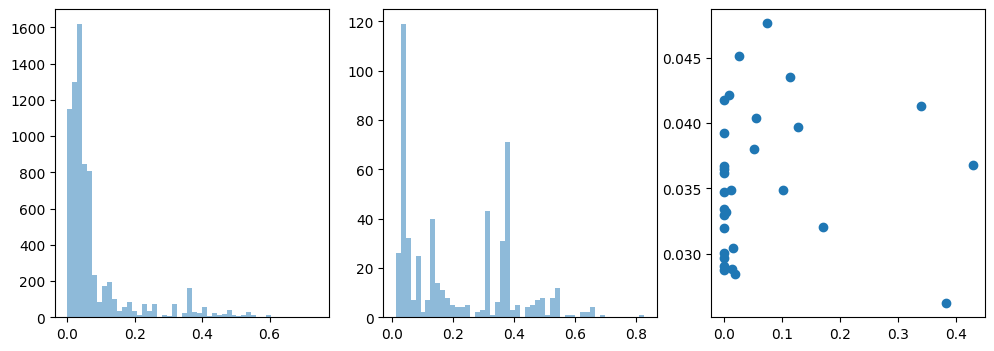

Average Survey Ratio: 0.03547771117521851
AUC = 0.74
tensor(1.5860) tensor([0]) tensor(0.)
tensor(0.6454) tensor([0]) tensor(0.)
tensor(1.8374) tensor([1]) tensor(0.0837)
tensor(0.8476) tensor([1]) tensor(-0.0152)
tensor(0.6319) tensor([0]) tensor(0.)
tensor(1.4546) tensor([0]) tensor(0.)
tensor(0.8021) tensor([1]) tensor(-0.0198)
episode:  19 loss:  tensor(0.8733, device='cuda:0', grad_fn=<AddBackward0>) average reward:  -0.15780075
tensor(1.1148) tensor([0]) tensor(0.)
tensor(0.8653) tensor([0]) tensor(0.)
tensor(0.4036) tensor([0]) tensor(0.)
tensor(1.9549) tensor([0]) tensor(0.)
episode:  20 loss:  tensor(0.8714, device='cuda:0', grad_fn=<AddBackward0>) average reward:  -0.16431487
tensor(0.2703) tensor([0]) tensor(0.)
tensor(3.5541) tensor([1]) tensor(0.2554)
tensor(1.2228) tensor([0]) tensor(0.)
tensor(3.7020) tensor([0]) tensor(0.)
tensor(0.9796) tensor([0]) tensor(0.)
tensor(2.0606) tensor([0]) tensor(0.)
tensor(3.0609) tensor([1]) tensor(0.2061)
tensor(1.0479) tensor([0]) tens

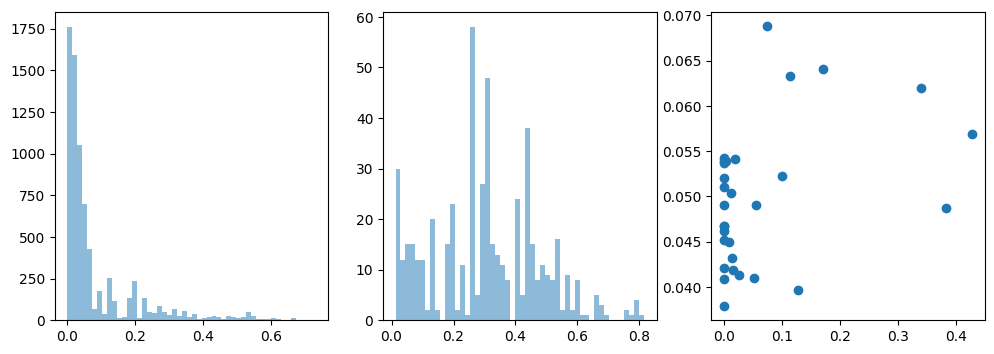

Average Survey Ratio: 0.04982957085728757
AUC = 0.86
tensor(0.4658) tensor([0]) tensor(0.)
tensor(1.9827) tensor([1]) tensor(0.0983)
tensor(0.7899) tensor([0]) tensor(0.)
tensor(1.1045) tensor([0]) tensor(0.)
tensor(1.2927) tensor([0]) tensor(0.)
tensor(3.3567) tensor([0]) tensor(0.)
tensor(1.4050) tensor([0]) tensor(0.)
tensor(0.5067) tensor([0]) tensor(0.)
tensor(1.9017) tensor([0]) tensor(0.)
tensor(1.3173) tensor([0]) tensor(0.)
episode:  39 loss:  tensor(0.8465, device='cuda:0', grad_fn=<AddBackward0>) average reward:  -0.14173016
tensor(0.2928) tensor([0]) tensor(0.)
tensor(0.6008) tensor([1]) tensor(-0.0399)
tensor(0.2810) tensor([0]) tensor(0.)
tensor(1.5497) tensor([0]) tensor(0.)
tensor(0.6051) tensor([0]) tensor(0.)
tensor(0.7089) tensor([0]) tensor(0.)
tensor(0.5139) tensor([0]) tensor(0.)
tensor(1.4844) tensor([0]) tensor(0.)
episode:  40 loss:  tensor(0.8214, device='cuda:0', grad_fn=<AddBackward0>) average reward:  -0.14098682
tensor(0.2348) tensor([0]) tensor(0.)
tensor

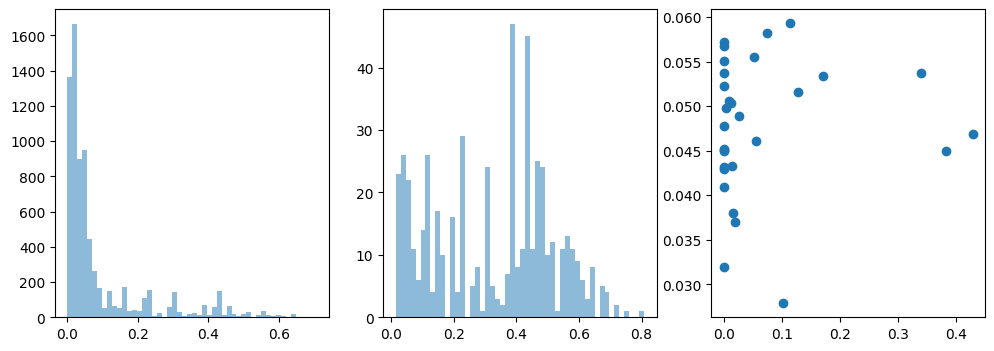

Average Survey Ratio: 0.0477410952622818
AUC = 0.85
tensor(0.3518) tensor([0]) tensor(0.)
tensor(0.4483) tensor([0]) tensor(0.)
tensor(0.3553) tensor([0]) tensor(0.)
tensor(0.5931) tensor([0]) tensor(0.)
tensor(0.2479) tensor([0]) tensor(0.)
tensor(0.4166) tensor([0]) tensor(0.)
tensor(0.5421) tensor([0]) tensor(0.)
tensor(0.4451) tensor([0]) tensor(0.)
episode:  59 loss:  tensor(0.8601, device='cuda:0', grad_fn=<AddBackward0>) average reward:  -0.15511495
tensor(0.8037) tensor([0]) tensor(0.)
tensor(1.2118) tensor([0]) tensor(0.)
tensor(0.2192) tensor([0]) tensor(0.)
tensor(1.8383) tensor([0]) tensor(0.)
episode:  60 loss:  tensor(0.9047, device='cuda:0', grad_fn=<AddBackward0>) average reward:  -0.15398794
tensor(1.7493) tensor([0]) tensor(0.)
tensor(0.5032) tensor([0]) tensor(0.)
tensor(1.8614) tensor([0]) tensor(0.)
tensor(0.4289) tensor([0]) tensor(0.)
tensor(0.9836) tensor([0]) tensor(0.)
tensor(1.2074) tensor([0]) tensor(0.)
tensor(1.2424) tensor([0]) tensor(0.)
episode:  61 los

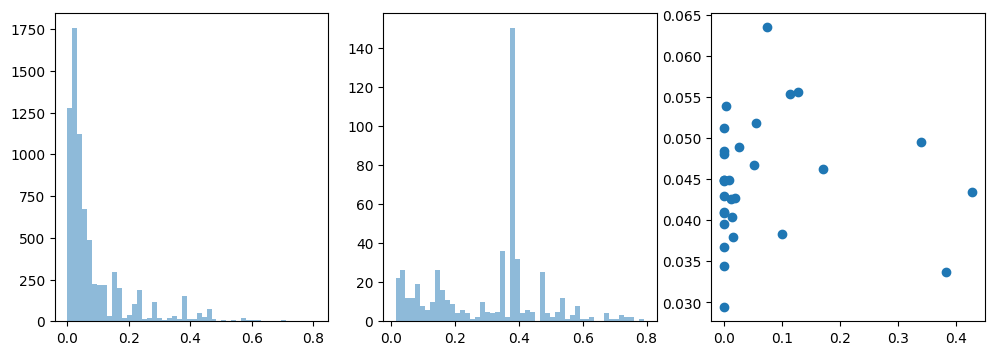

Average Survey Ratio: 0.044768428508202666
AUC = 0.85
tensor(1.7584) tensor([0]) tensor(0.)
tensor(0.9251) tensor([0]) tensor(0.)
tensor(1.5407) tensor([0]) tensor(0.)
tensor(0.5710) tensor([0]) tensor(0.)
tensor(0.7717) tensor([0]) tensor(0.)
tensor(1.6037) tensor([0]) tensor(0.)
tensor(4.6793) tensor([0]) tensor(0.)
episode:  79 loss:  tensor(0.8299, device='cuda:0', grad_fn=<AddBackward0>) average reward:  -0.1457509
tensor(0.7596) tensor([0]) tensor(0.)
tensor(1.0302) tensor([0]) tensor(0.)
tensor(1.0014) tensor([0]) tensor(0.)
tensor(1.8109) tensor([0]) tensor(0.)
tensor(0.7199) tensor([0]) tensor(0.)
tensor(1.5383) tensor([1]) tensor(0.0538)
tensor(0.3318) tensor([0]) tensor(0.)
episode:  80 loss:  tensor(0.8865, device='cuda:0', grad_fn=<AddBackward0>) average reward:  -0.1460254
tensor(3.1145) tensor([0]) tensor(0.)
tensor(0.7410) tensor([0]) tensor(0.)
tensor(3.6872) tensor([0]) tensor(0.)
tensor(1.3316) tensor([0]) tensor(0.)
tensor(2.0814) tensor([1]) tensor(0.1081)
tensor(3

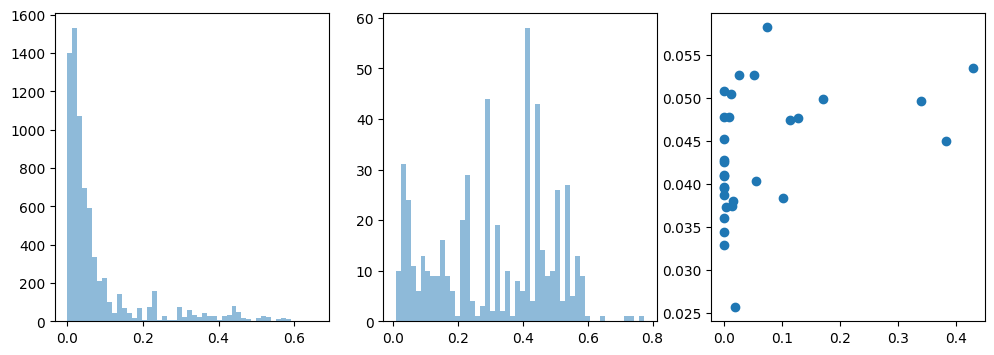

Average Survey Ratio: 0.04345977290692874
AUC = 0.86
tensor(0.8244) tensor([0]) tensor(0.)
tensor(2.5002) tensor([1]) tensor(0.1500)
episode:  99 loss:  tensor(0.9050, device='cuda:0', grad_fn=<AddBackward0>) average reward:  -0.15047777
61 : 10 0 303 0 0
89 : 13 0 356 0 0
23 : 11 0 310 0 0
130 : 12 3 356 0 3
121 : 12 3 258 1 1
72 : 14 5 347 0 5
105 : 12 18 342 0 10
73 : 10 82 242 26 26
113 : 11 0 269 0 0
144 : 12 0 332 0 0
67 : 13 48 281 6 8
81 : 14 0 333 0 0
138 : 16 0 335 0 0
29 : 12 0 334 0 0
127 : 14 0 317 0 0
62 : 8 4 263 4 4
56 : 17 128 299 0 0
50 : 12 7 351 7 7
49 : 14 29 253 0 0
65 : 13 7 266 0 0
18 : 15 19 347 4 15
135 : 13 0 407 0 0
76 : 12 102 267 7 8
64 : 12 0 306 0 0
10 : 8 32 252 0 0
24 : 11 29 287 5 5
84 : 8 1 241 1 1
51 : 10 14 189 10 10
110 : 9 0 278 0 0
147 : 14 0 327 0 0


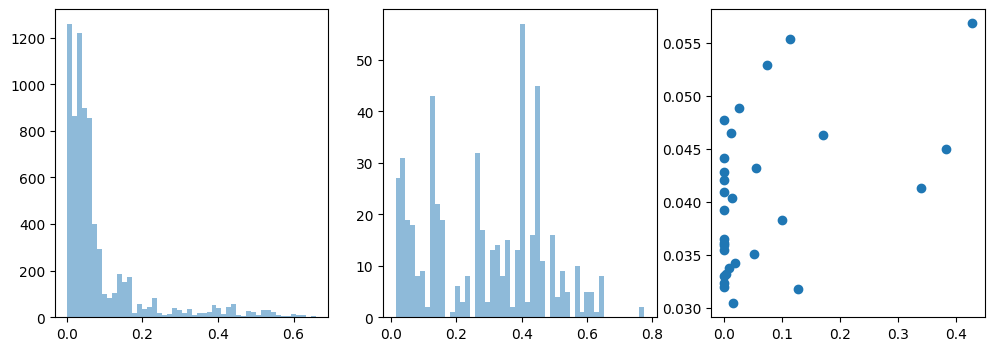

Average Survey Ratio: 0.0403846640251667
AUC = 0.83
61 : 303 0 303 0 0
89 : 356 0 356 0 0
23 : 310 0 310 0 0
130 : 356 3 356 0 0
121 : 258 3 258 3 3
72 : 347 5 347 5 5
105 : 342 18 342 7 11
73 : 242 82 242 2 5
113 : 269 0 269 0 0
144 : 332 0 332 0 0
67 : 281 48 281 2 14
81 : 333 0 333 0 0
138 : 335 0 335 0 0
29 : 334 0 334 0 0
127 : 317 0 317 0 0
62 : 263 4 263 4 4
56 : 299 128 299 0 4
50 : 351 7 351 7 7
49 : 253 29 253 5 9
65 : 266 7 266 1 1
18 : 347 19 347 13 13
135 : 407 0 407 0 0
76 : 267 102 267 2 12
64 : 306 0 306 0 0
10 : 252 32 252 5 9
24 : 287 29 287 15 23
84 : 241 1 241 1 1
51 : 189 14 189 2 5
110 : 278 0 278 0 0
147 : 327 0 327 0 0


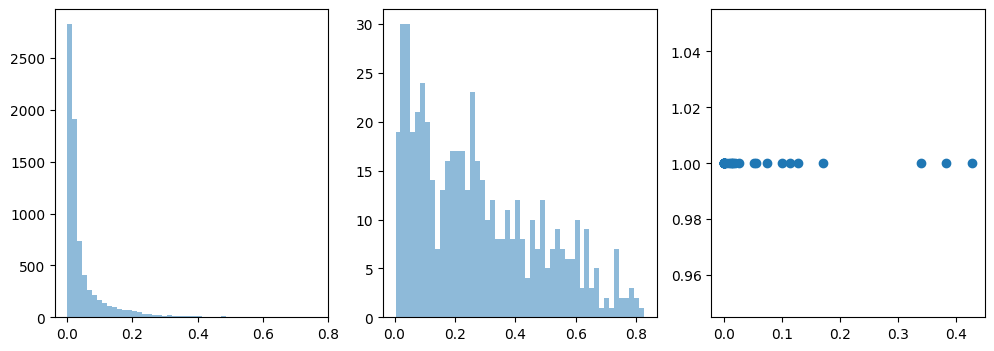

Average Survey Ratio: 1.0
AUC = 0.89
torch.Size([30072, 143]) torch.Size([7144, 143])
581 1712 7144
XgBoost: AUC = 0.86
Device set to : cuda:0
tensor(0.7355) tensor([1]) tensor(0.0735)
tensor(1.4247) tensor([1]) tensor(0.1425)
tensor(1.5055) tensor([1]) tensor(0.1505)
tensor(1.6924) tensor([1]) tensor(0.1692)
tensor(2.0545) tensor([1]) tensor(0.2054)
tensor(2.5179) tensor([1]) tensor(0.2518)
tensor(1.4662) tensor([1]) tensor(0.1466)
tensor(2.4531) tensor([1]) tensor(0.2453)
tensor(1.3766) tensor([1]) tensor(0.1377)
tensor(0.5263) tensor([1]) tensor(0.0526)
tensor(4.0102) tensor([1]) tensor(0.4010)
tensor(2.3675) tensor([1]) tensor(0.2367)
tensor(2.9221) tensor([1]) tensor(0.2922)
tensor(3.1097) tensor([1]) tensor(0.3110)
tensor(3.3517) tensor([1]) tensor(0.3352)
tensor(4.8028) tensor([1]) tensor(0.4803)
tensor(1.6254) tensor([1]) tensor(0.1625)
tensor(6.3111) tensor([1]) tensor(0.6311)
tensor(4.3778) tensor([1]) tensor(0.4378)
tensor(2.5820) tensor([1]) tensor(0.2582)
tensor(2.5707) te

tensor(0.8035) tensor([0]) tensor(0.)
tensor(1.4916) tensor([0]) tensor(0.)
tensor(0.0356) tensor([1]) tensor(0.0036)
tensor(0.0345) tensor([1]) tensor(0.0034)
tensor(0.2011) tensor([0]) tensor(0.)
tensor(0.6027) tensor([0]) tensor(0.)
tensor(0.2525) tensor([1]) tensor(0.0252)
tensor(1.8620) tensor([1]) tensor(0.1862)
tensor(0.3500) tensor([0]) tensor(0.)
tensor(0.2045) tensor([1]) tensor(0.0205)
tensor(0.6011) tensor([1]) tensor(0.0601)
tensor(1.2291) tensor([1]) tensor(0.1229)
tensor(0.4417) tensor([0]) tensor(0.)
tensor(0.8985) tensor([1]) tensor(0.0899)
tensor(0.2181) tensor([1]) tensor(0.0218)
tensor(0.4398) tensor([0]) tensor(0.)
tensor(0.1635) tensor([0]) tensor(0.)
tensor(0.1973) tensor([1]) tensor(0.0197)
tensor(0.2825) tensor([1]) tensor(0.0282)
tensor(0.4126) tensor([0]) tensor(0.)
tensor(2.5341) tensor([0]) tensor(0.)
tensor(1.3373) tensor([0]) tensor(0.)
tensor(3.3078) tensor([0]) tensor(0.)
tensor(0.9089) tensor([1]) tensor(0.0909)
tensor(1.0044) tensor([0]) tensor(0.)
te

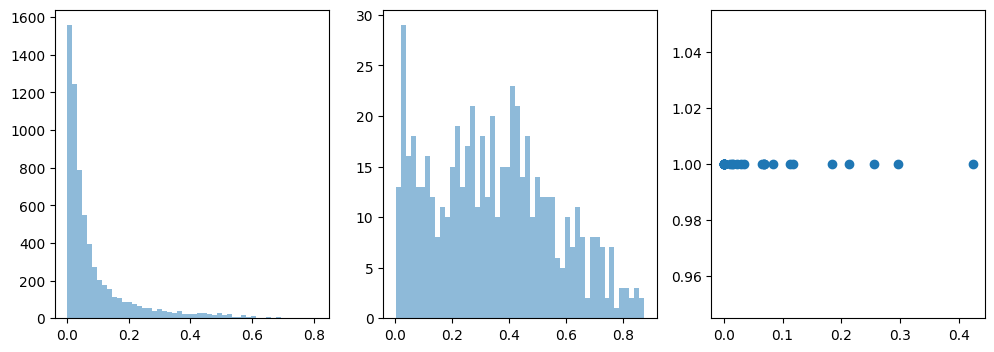

Average Survey Ratio: 1.0
AUC = 0.86
3 : 126 0 354 0 0
97 : 114 22 319 3 10
129 : 101 4 304 2 4
109 : 89 0 249 0 0
119 : 105 73 286 0 1
93 : 110 38 323 0 9
88 : 107 3 299 3 3
55 : 124 11 324 11 11
90 : 76 0 211 0 0
28 : 87 30 268 1 2
8 : 114 29 344 5 8
48 : 119 24 348 3 13
125 : 47 23 125 6 7
66 : 111 0 331 0 0
92 : 70 0 176 0 0
116 : 50 9 139 3 3
52 : 104 5 323 3 5
7 : 77 50 234 0 0
82 : 85 0 235 0 0
20 : 85 0 233 0 0
41 : 72 15 220 9 9
25 : 99 86 289 0 0
111 : 85 0 247 0 0
47 : 40 0 100 0 0
26 : 102 139 328 0 4
12 : 97 9 302 5 7
77 : 91 0 267 0 0
44 : 102 6 277 0 1
128 : 113 0 306 0 0
75 : 100 0 301 0 0


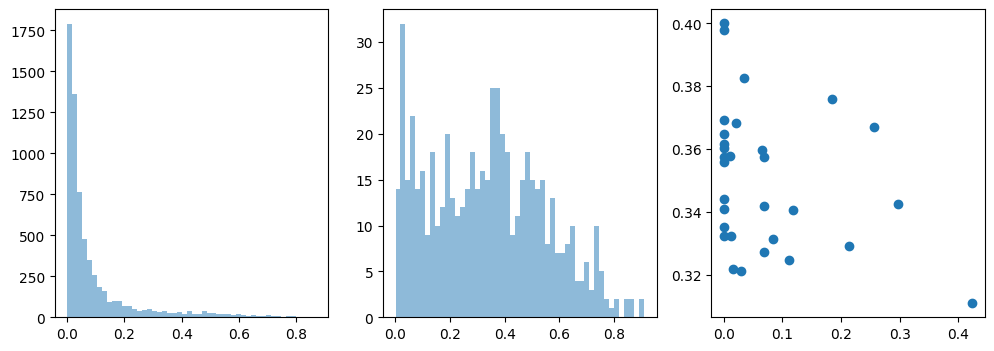

Average Survey Ratio: 0.350414224258179
AUC = 0.85
3 : 26 0 354 0 0
97 : 27 22 319 7 7
129 : 26 4 304 4 4
109 : 21 0 249 0 0
119 : 19 73 286 4 13
93 : 23 38 323 2 17
88 : 24 3 299 3 3
55 : 25 11 324 11 11
90 : 20 0 211 0 0
28 : 23 30 268 0 0
8 : 30 29 344 3 6
48 : 25 24 348 12 16
125 : 12 23 125 7 7
66 : 25 0 331 0 0
92 : 12 0 176 0 0
116 : 12 9 139 2 4
52 : 27 5 323 5 5
7 : 20 50 234 0 0
82 : 23 0 235 0 0
20 : 16 0 233 0 0
41 : 20 15 220 4 7
25 : 20 86 289 0 4
111 : 22 0 247 0 0
47 : 11 0 100 0 0
26 : 24 139 328 1 1
12 : 27 9 302 0 6
77 : 24 0 267 0 0
44 : 26 6 277 0 1
128 : 27 0 306 0 0
75 : 26 0 301 0 0


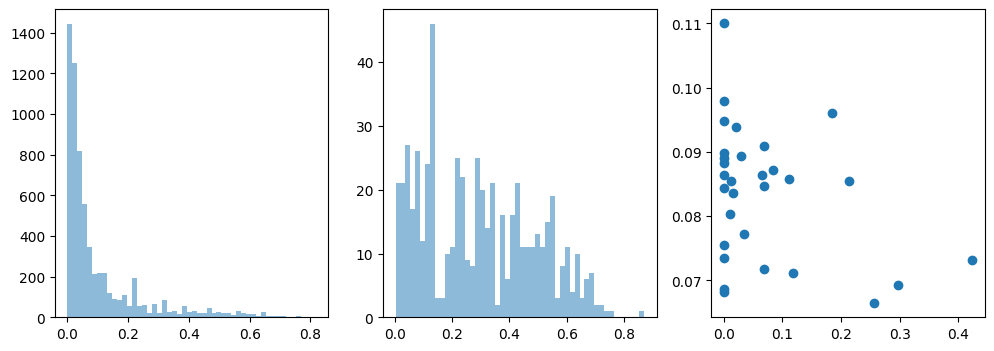

Average Survey Ratio: 0.0834813516759992
AUC = 0.81
tensor(0.6100) tensor([0]) tensor(0.)
tensor(0.0818) tensor([0]) tensor(0.)
tensor(0.1575) tensor([1]) tensor(-0.0842)
tensor(0.2501) tensor([0]) tensor(0.)
tensor(0.0935) tensor([0]) tensor(0.)
tensor(0.2184) tensor([0]) tensor(0.)
tensor(0.4046) tensor([0]) tensor(0.)
tensor(0.7755) tensor([0]) tensor(0.)
tensor(0.3144) tensor([0]) tensor(0.)
tensor(0.5459) tensor([1]) tensor(-0.0454)
tensor(0.3655) tensor([0]) tensor(0.)
tensor(0.2784) tensor([1]) tensor(-0.0722)
tensor(0.0638) tensor([1]) tensor(-0.0936)
tensor(0.0684) tensor([1]) tensor(-0.0932)
episode:  2 loss:  tensor(0.8359, device='cuda:0', grad_fn=<AddBackward0>) average reward:  -0.13703214
tensor(0.0513) tensor([0]) tensor(0.)
tensor(0.4114) tensor([1]) tensor(-0.0589)
tensor(0.2254) tensor([0]) tensor(0.)
tensor(0.4660) tensor([0]) tensor(0.)
tensor(0.1062) tensor([0]) tensor(0.)
episode:  3 loss:  tensor(0.8469, device='cuda:0', grad_fn=<AddBackward0>) average reward:  

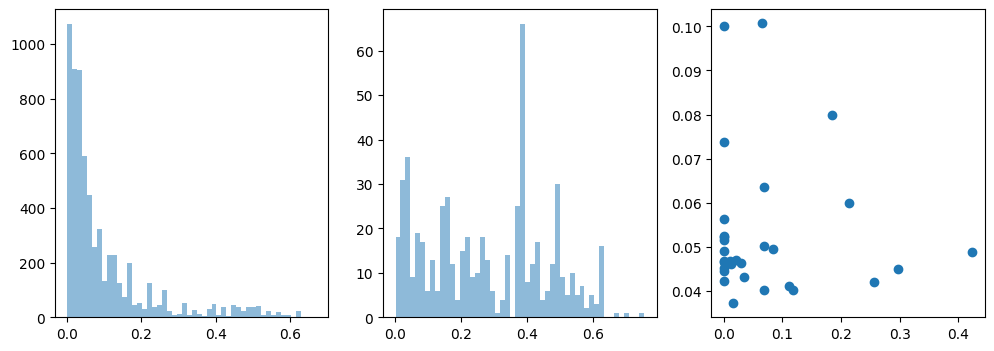

Average Survey Ratio: 0.05293518499096029
AUC = 0.79
tensor(0.6019) tensor([0]) tensor(0.)
tensor(1.1629) tensor([0]) tensor(0.)
tensor(0.6182) tensor([0]) tensor(0.)
tensor(1.4585) tensor([0]) tensor(0.)
tensor(1.8313) tensor([1]) tensor(0.0831)
tensor(1.1825) tensor([0]) tensor(0.)
tensor(2.7501) tensor([1]) tensor(0.1750)
tensor(0.8218) tensor([0]) tensor(0.)
tensor(1.4680) tensor([0]) tensor(0.)
tensor(2.7239) tensor([0]) tensor(0.)
episode:  19 loss:  tensor(0.7955, device='cuda:0', grad_fn=<AddBackward0>) average reward:  -0.15093215
tensor(0.6037) tensor([0]) tensor(0.)
tensor(3.8088) tensor([0]) tensor(0.)
episode:  20 loss:  tensor(0.8040, device='cuda:0', grad_fn=<AddBackward0>) average reward:  -0.14895199
tensor(0.1275) tensor([0]) tensor(0.)
tensor(0.2828) tensor([1]) tensor(-0.0717)
tensor(0.3100) tensor([0]) tensor(0.)
tensor(0.1837) tensor([0]) tensor(0.)
tensor(0.3400) tensor([0]) tensor(0.)
tensor(0.7041) tensor([0]) tensor(0.)
tensor(0.6327) tensor([0]) tensor(0.)
te

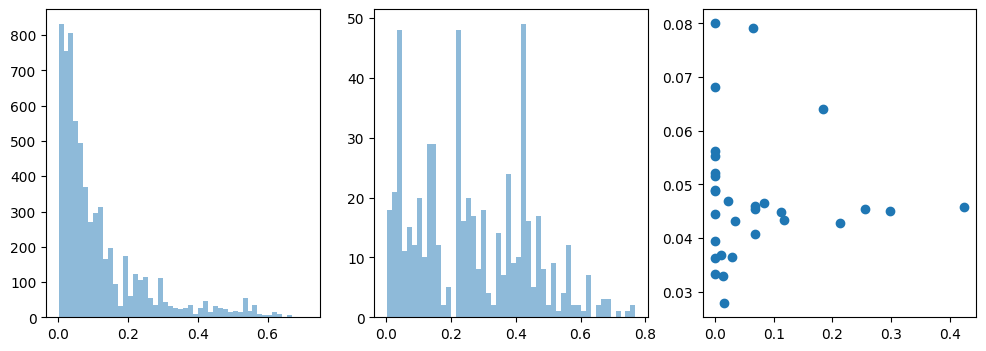

Average Survey Ratio: 0.04758657315636497
AUC = 0.76
tensor(0.7159) tensor([1]) tensor(-0.0284)
tensor(0.3670) tensor([1]) tensor(-0.0633)
tensor(0.2695) tensor([0]) tensor(0.)
tensor(0.3170) tensor([1]) tensor(-0.0683)
tensor(1.8448) tensor([0]) tensor(0.)
tensor(1.2986) tensor([1]) tensor(0.0299)
tensor(1.2299) tensor([0]) tensor(0.)
tensor(0.8410) tensor([0]) tensor(0.)
episode:  39 loss:  tensor(0.8437, device='cuda:0', grad_fn=<AddBackward0>) average reward:  -0.13814132
tensor(0.5659) tensor([0]) tensor(0.)
tensor(0.2748) tensor([0]) tensor(0.)
tensor(0.7383) tensor([0]) tensor(0.)
tensor(0.8791) tensor([0]) tensor(0.)
tensor(0.2829) tensor([0]) tensor(0.)
tensor(0.4695) tensor([0]) tensor(0.)
tensor(0.1953) tensor([0]) tensor(0.)
episode:  40 loss:  tensor(0.8051, device='cuda:0', grad_fn=<AddBackward0>) average reward:  -0.14075245
tensor(1.1771) tensor([0]) tensor(0.)
tensor(0.6044) tensor([0]) tensor(0.)
tensor(0.3518) tensor([0]) tensor(0.)
tensor(0.5122) tensor([0]) tensor(

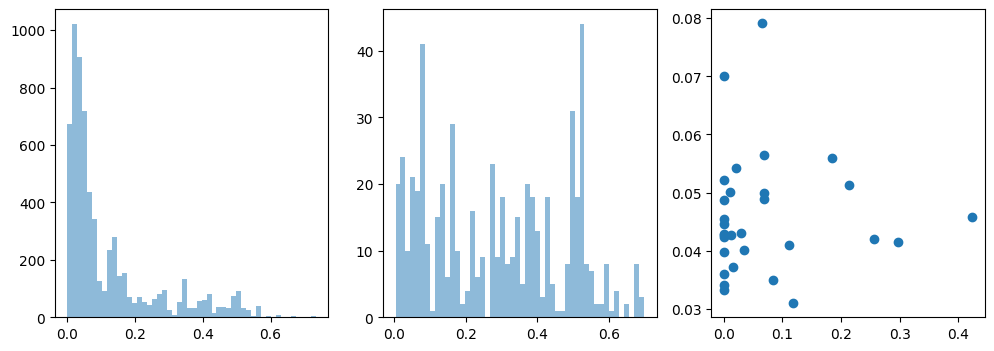

Average Survey Ratio: 0.04590406544472632
AUC = 0.77
episode:  59 loss:  tensor(0.8078, device='cuda:0', grad_fn=<AddBackward0>) average reward:  -0.14072743
tensor(1.4919) tensor([0]) tensor(0.)
tensor(1.2184) tensor([0]) tensor(0.)
tensor(0.7243) tensor([0]) tensor(0.)
tensor(1.1900) tensor([0]) tensor(0.)
tensor(0.3796) tensor([0]) tensor(0.)
tensor(2.1541) tensor([0]) tensor(0.)
tensor(0.9986) tensor([0]) tensor(0.)
tensor(0.8444) tensor([0]) tensor(0.)
tensor(0.3924) tensor([1]) tensor(-0.0608)
tensor(0.3744) tensor([0]) tensor(0.)
episode:  60 loss:  tensor(0.8853, device='cuda:0', grad_fn=<AddBackward0>) average reward:  -0.14190605
tensor(0.1963) tensor([0]) tensor(0.)
tensor(0.5342) tensor([0]) tensor(0.)
episode:  61 loss:  tensor(0.8233, device='cuda:0', grad_fn=<AddBackward0>) average reward:  -0.14200766
tensor(0.6813) tensor([0]) tensor(0.)
tensor(0.4592) tensor([1]) tensor(-0.0541)
tensor(0.0545) tensor([0]) tensor(0.)
episode:  62 loss:  tensor(0.8754, device='cuda:0', 

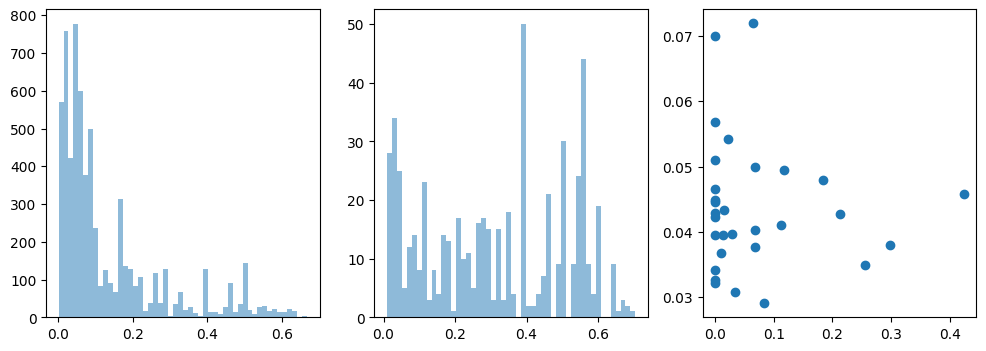

Average Survey Ratio: 0.04369596996893502
AUC = 0.76
tensor(0.5996) tensor([0]) tensor(0.)
tensor(0.6171) tensor([0]) tensor(0.)
tensor(0.5854) tensor([1]) tensor(-0.0415)
tensor(1.1055) tensor([0]) tensor(0.)
tensor(0.1672) tensor([0]) tensor(0.)
tensor(0.1542) tensor([0]) tensor(0.)
tensor(0.1367) tensor([0]) tensor(0.)
episode:  79 loss:  tensor(0.8088, device='cuda:0', grad_fn=<AddBackward0>) average reward:  -0.13210888
tensor(0.2758) tensor([0]) tensor(0.)
tensor(4.6924) tensor([0]) tensor(0.)
tensor(0.0519) tensor([0]) tensor(0.)
tensor(0.1609) tensor([0]) tensor(0.)
episode:  80 loss:  tensor(0.8070, device='cuda:0', grad_fn=<AddBackward0>) average reward:  -0.13243815
tensor(1.1811) tensor([0]) tensor(0.)
tensor(0.4084) tensor([0]) tensor(0.)
tensor(0.6169) tensor([1]) tensor(-0.0383)
tensor(0.5803) tensor([0]) tensor(0.)
tensor(1.2036) tensor([1]) tensor(0.0204)
tensor(0.9935) tensor([0]) tensor(0.)
tensor(0.7529) tensor([0]) tensor(0.)
tensor(0.2879) tensor([0]) tensor(0.)
e

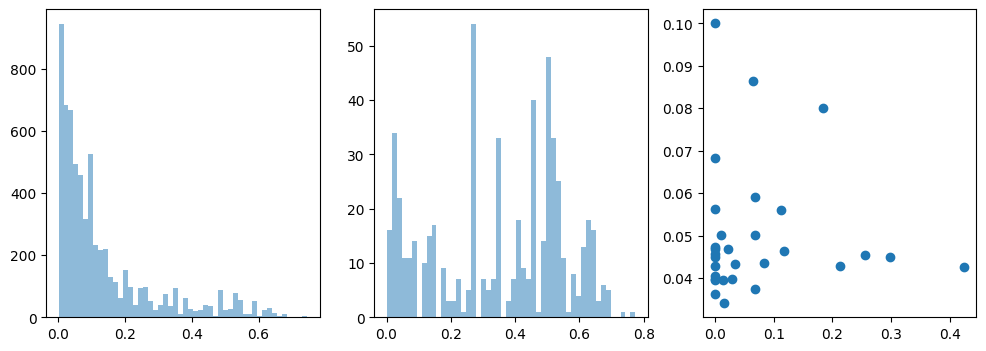

Average Survey Ratio: 0.04989182698882763
AUC = 0.79
tensor(0.4491) tensor([0]) tensor(0.)
tensor(1.3610) tensor([0]) tensor(0.)
tensor(1.6130) tensor([1]) tensor(0.0613)
tensor(0.1046) tensor([0]) tensor(0.)
tensor(0.0396) tensor([0]) tensor(0.)
tensor(0.3472) tensor([1]) tensor(-0.0653)
episode:  99 loss:  tensor(0.8071, device='cuda:0', grad_fn=<AddBackward0>) average reward:  -0.14856759
3 : 9 0 354 0 0
97 : 11 22 319 0 0
129 : 10 4 304 0 4
109 : 9 0 249 0 0
119 : 10 73 286 0 0
93 : 12 38 323 5 12
88 : 10 3 299 3 3
55 : 10 11 324 11 11
90 : 10 0 211 0 0
28 : 10 30 268 0 1
8 : 9 29 344 2 3
48 : 10 24 348 9 15
125 : 8 23 125 18 18
66 : 8 0 331 0 0
92 : 9 0 176 0 0
116 : 11 9 139 3 4
52 : 7 5 323 1 5
7 : 9 50 234 0 0
82 : 9 0 235 0 0
20 : 10 0 233 0 0
41 : 9 15 220 3 14
25 : 9 86 289 0 0
111 : 9 0 247 0 0
47 : 7 0 100 0 0
26 : 12 139 328 11 11
12 : 9 9 302 0 0
77 : 10 0 267 0 0
44 : 11 6 277 0 2
128 : 12 0 306 0 0
75 : 8 0 301 0 0


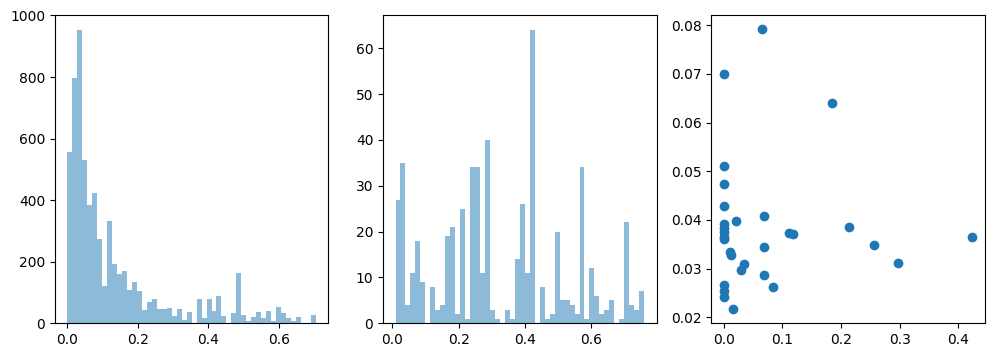

Average Survey Ratio: 0.03842005788236143
AUC = 0.77
3 : 354 0 354 0 0
97 : 319 22 319 3 8
129 : 304 4 304 4 4
109 : 249 0 249 0 0
119 : 286 73 286 1 1
93 : 323 38 323 5 16
88 : 299 3 299 3 3
55 : 324 11 324 11 11
90 : 211 0 211 0 0
28 : 268 30 268 2 5
8 : 344 29 344 2 7
48 : 348 24 348 9 16
125 : 125 23 125 5 6
66 : 331 0 331 0 0
92 : 176 0 176 0 0
116 : 139 9 139 5 6
52 : 323 5 323 5 5
7 : 234 50 234 2 5
82 : 235 0 235 0 0
20 : 233 0 233 0 0
41 : 220 15 220 8 8
25 : 289 86 289 0 0
111 : 247 0 247 0 0
47 : 100 0 100 0 0
26 : 328 139 328 0 4
12 : 302 9 302 8 9
77 : 267 0 267 0 0
44 : 277 6 277 0 2
128 : 306 0 306 0 0
75 : 301 0 301 0 0


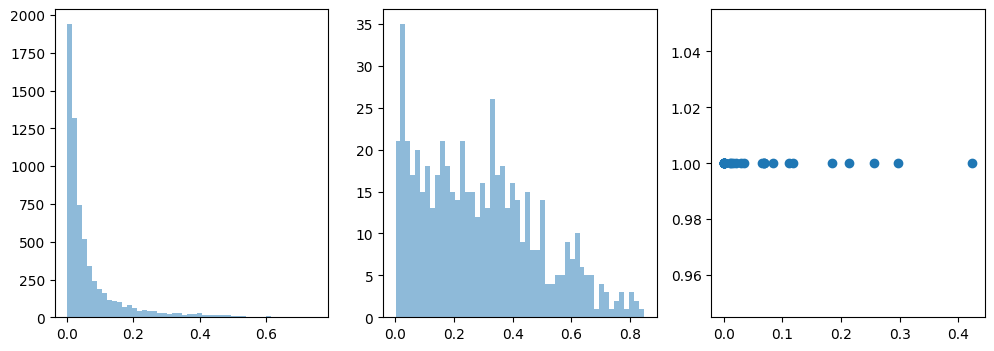

Average Survey Ratio: 1.0
AUC = 0.85
torch.Size([30048, 143]) torch.Size([7168, 143])
602 1261 7168
XgBoost: AUC = 0.93
Device set to : cuda:0
tensor(6.5533) tensor([1]) tensor(0.6553)
tensor(4.7990) tensor([1]) tensor(0.4799)
tensor(6.8272) tensor([1]) tensor(0.6827)
tensor(6.1890) tensor([1]) tensor(0.6189)
tensor(2.2001) tensor([1]) tensor(0.2200)
tensor(3.0601) tensor([1]) tensor(0.3060)
tensor(2.2245) tensor([1]) tensor(0.2225)
tensor(7.2602) tensor([1]) tensor(0.7260)
tensor(1.0838) tensor([1]) tensor(0.1084)
tensor(1.6371) tensor([1]) tensor(0.1637)
tensor(2.2086) tensor([1]) tensor(0.2209)
tensor(2.2617) tensor([1]) tensor(0.2262)
tensor(2.3786) tensor([1]) tensor(0.2379)
tensor(3.1534) tensor([1]) tensor(0.3153)
tensor(2.5288) tensor([1]) tensor(0.2529)
tensor(3.1732) tensor([1]) tensor(0.3173)
tensor(3.8968) tensor([1]) tensor(0.3897)
tensor(1.5562) tensor([1]) tensor(0.1556)
tensor(3.6972) tensor([1]) tensor(0.3697)
tensor(3.2094) tensor([1]) tensor(0.3209)
tensor(7.3387) te

tensor(0.5895) tensor([0]) tensor(0.)
tensor(0.6930) tensor([0]) tensor(0.)
tensor(0.9346) tensor([1]) tensor(0.0935)
tensor(0.9253) tensor([0]) tensor(0.)
tensor(0.3835) tensor([1]) tensor(0.0383)
tensor(1.4051) tensor([1]) tensor(0.1405)
tensor(0.6538) tensor([0]) tensor(0.)
tensor(0.3839) tensor([1]) tensor(0.0384)
tensor(0.0537) tensor([0]) tensor(0.)
tensor(0.2750) tensor([0]) tensor(0.)
tensor(0.1873) tensor([0]) tensor(0.)
tensor(0.3157) tensor([1]) tensor(0.0316)
tensor(0.3922) tensor([0]) tensor(0.)
tensor(0.7345) tensor([0]) tensor(0.)
tensor(0.5146) tensor([0]) tensor(0.)
tensor(0.4211) tensor([0]) tensor(0.)
tensor(0.2940) tensor([1]) tensor(0.0294)
tensor(0.3112) tensor([0]) tensor(0.)
tensor(0.7653) tensor([0]) tensor(0.)
tensor(2.0593) tensor([0]) tensor(0.)
tensor(1.3440) tensor([0]) tensor(0.)
tensor(0.3225) tensor([0]) tensor(0.)
tensor(0.4468) tensor([0]) tensor(0.)
tensor(0.6772) tensor([0]) tensor(0.)
tensor(2.5967) tensor([0]) tensor(0.)
tensor(3.2741) tensor([0])

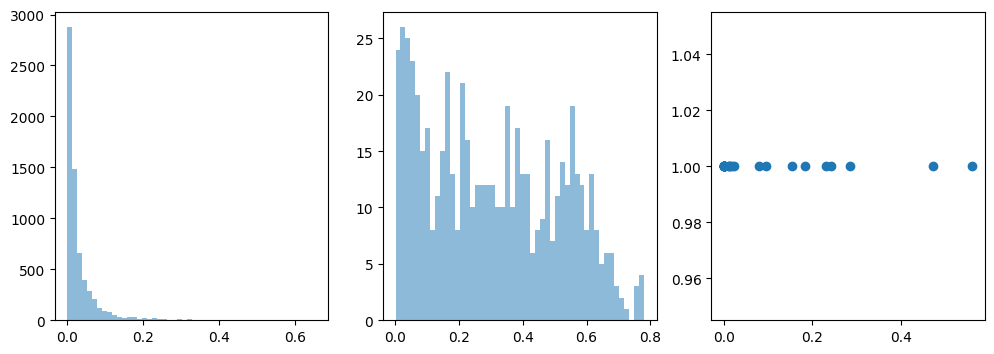

Average Survey Ratio: 1.0
AUC = 0.93
60 : 20 14 49 6 7
95 : 32 15 97 13 15
54 : 110 4 309 0 3
15 : 110 0 315 0 0
126 : 125 0 341 0 0
100 : 121 0 343 0 0
58 : 42 3 127 3 3
63 : 120 161 341 5 17
145 : 96 0 267 0 0
148 : 97 5 284 3 5
141 : 126 0 342 0 0
74 : 121 185 329 0 7
142 : 126 0 341 0 0
108 : 122 0 333 0 0
86 : 57 0 187 0 0
150 : 116 5 333 2 5
35 : 120 63 343 7 15
79 : 118 0 342 0 0
13 : 108 4 314 4 4
14 : 49 0 153 0 0
42 : 106 0 295 0 0
112 : 53 0 161 0 0
104 : 108 0 296 0 0
4 : 114 0 331 0 0
45 : 66 0 199 0 0
80 : 89 64 263 0 6
37 : 97 27 283 8 14
1 : 104 22 279 10 17
78 : 115 0 313 0 0
69 : 37 28 121 6 8


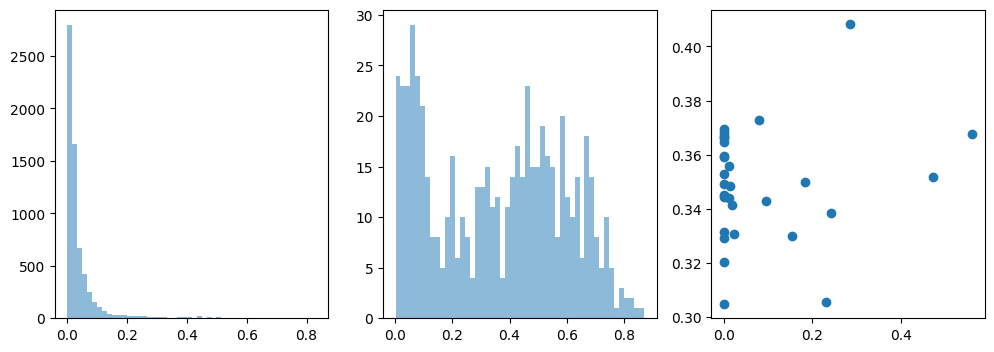

Average Survey Ratio: 0.34957323268524243
AUC = 0.92
60 : 10 14 49 5 5
95 : 10 15 97 11 15
54 : 23 4 309 0 4
15 : 25 0 315 0 0
126 : 24 0 341 0 0
100 : 22 0 343 0 0
58 : 10 3 127 3 3
63 : 31 161 341 8 9
145 : 21 0 267 0 0
148 : 23 5 284 0 5
141 : 26 0 342 0 0
74 : 31 185 329 1 6
142 : 27 0 341 0 0
108 : 29 0 333 0 0
86 : 20 0 187 0 0
150 : 28 5 333 5 5
35 : 28 63 343 8 32
79 : 25 0 342 0 0
13 : 25 4 314 4 4
14 : 14 0 153 0 0
42 : 23 0 295 0 0
112 : 15 0 161 0 0
104 : 24 0 296 0 0
4 : 21 0 331 0 0
45 : 19 0 199 0 0
80 : 19 64 263 0 3
37 : 21 27 283 5 7
1 : 26 22 279 9 16
78 : 25 0 313 0 0
69 : 14 28 121 6 7


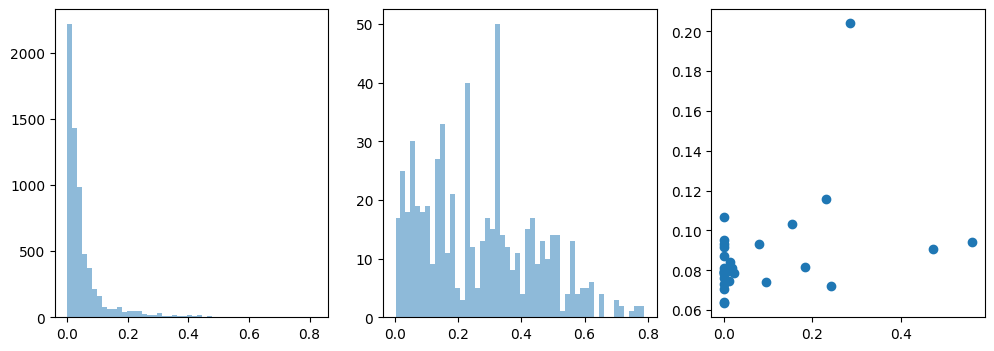

Average Survey Ratio: 0.08748446371157634
AUC = 0.89
tensor(1.4139) tensor([0]) tensor(0.)
tensor(1.0499) tensor([1]) tensor(0.0050)
tensor(1.6819) tensor([0]) tensor(0.)
tensor(1.2414) tensor([0]) tensor(0.)
tensor(1.6586) tensor([0]) tensor(0.)
tensor(0.5016) tensor([1]) tensor(-0.0498)
tensor(0.4632) tensor([1]) tensor(-0.0537)
tensor(0.4432) tensor([1]) tensor(-0.0557)
tensor(5.8613) tensor([1]) tensor(0.4861)
tensor(0.1208) tensor([1]) tensor(-0.0879)
tensor(0.2055) tensor([1]) tensor(-0.0794)
tensor(0.0446) tensor([1]) tensor(-0.0955)
tensor(1.0029) tensor([0]) tensor(0.)
tensor(0.0496) tensor([0]) tensor(0.)
tensor(0.3611) tensor([1]) tensor(-0.0639)
tensor(0.0181) tensor([1]) tensor(-0.0982)
tensor(0.0306) tensor([1]) tensor(-0.0969)
episode:  2 loss:  tensor(0.8400, device='cuda:0', grad_fn=<AddBackward0>) average reward:  -0.16010787
tensor(1.0865) tensor([1]) tensor(0.0086)
tensor(1.3208) tensor([1]) tensor(0.0321)
episode:  3 loss:  tensor(0.8277, device='cuda:0', grad_fn=<

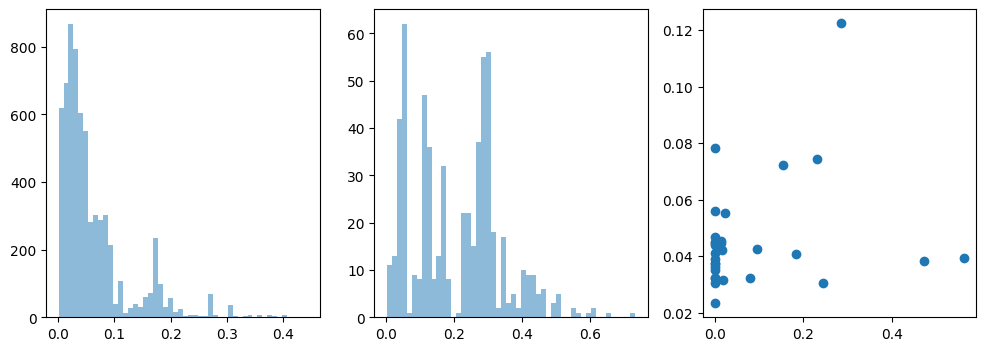

Average Survey Ratio: 0.04568885013747649
AUC = 0.85
tensor(1.1454) tensor([0]) tensor(0.)
tensor(0.1986) tensor([0]) tensor(0.)
episode:  19 loss:  tensor(0.8437, device='cuda:0', grad_fn=<AddBackward0>) average reward:  -0.14284967
tensor(1.1292) tensor([0]) tensor(0.)
tensor(0.9253) tensor([0]) tensor(0.)
tensor(0.5720) tensor([1]) tensor(-0.0428)
tensor(1.1575) tensor([0]) tensor(0.)
episode:  20 loss:  tensor(0.8546, device='cuda:0', grad_fn=<AddBackward0>) average reward:  -0.14114158
tensor(1.1712) tensor([0]) tensor(0.)
tensor(0.7444) tensor([0]) tensor(0.)
episode:  21 loss:  tensor(0.8038, device='cuda:0', grad_fn=<AddBackward0>) average reward:  -0.1401698
tensor(0.2532) tensor([0]) tensor(0.)
tensor(0.0537) tensor([0]) tensor(0.)
tensor(0.1420) tensor([0]) tensor(0.)
tensor(0.5473) tensor([0]) tensor(0.)
tensor(0.2792) tensor([0]) tensor(0.)
tensor(0.9387) tensor([0]) tensor(0.)
episode:  22 loss:  tensor(0.8234, device='cuda:0', grad_fn=<AddBackward0>) average reward:  -0.

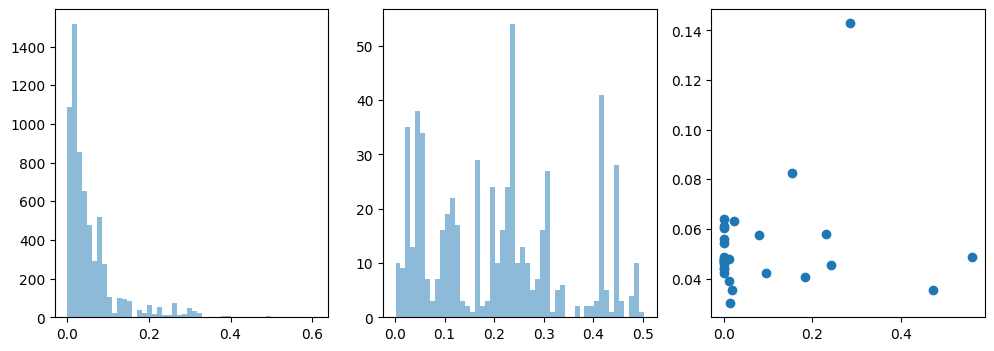

Average Survey Ratio: 0.05240329914689556
AUC = 0.84
tensor(0.6413) tensor([0]) tensor(0.)
tensor(5.1794) tensor([0]) tensor(0.)
tensor(1.2058) tensor([0]) tensor(0.)
tensor(1.8194) tensor([0]) tensor(0.)
episode:  39 loss:  tensor(0.8857, device='cuda:0', grad_fn=<AddBackward0>) average reward:  -0.15541539
tensor(2.0494) tensor([0]) tensor(0.)
tensor(0.4465) tensor([0]) tensor(0.)
tensor(1.9229) tensor([0]) tensor(0.)
tensor(1.6394) tensor([0]) tensor(0.)
tensor(0.2488) tensor([0]) tensor(0.)
episode:  40 loss:  tensor(0.8316, device='cuda:0', grad_fn=<AddBackward0>) average reward:  -0.15921657
tensor(2.4678) tensor([0]) tensor(0.)
tensor(3.3863) tensor([0]) tensor(0.)
tensor(1.1098) tensor([0]) tensor(0.)
tensor(1.0653) tensor([0]) tensor(0.)
tensor(0.5378) tensor([0]) tensor(0.)
tensor(0.3921) tensor([0]) tensor(0.)
tensor(0.5684) tensor([0]) tensor(0.)
tensor(0.3706) tensor([0]) tensor(0.)
tensor(0.5314) tensor([1]) tensor(-0.0469)
episode:  41 loss:  tensor(0.8523, device='cuda:

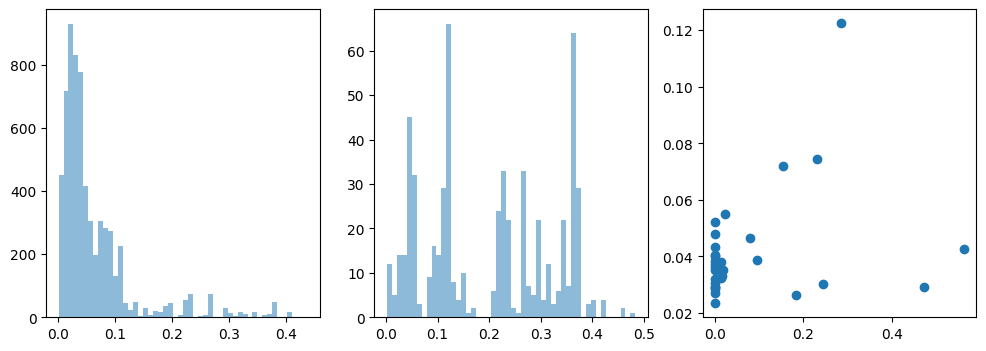

Average Survey Ratio: 0.04163110399201634
AUC = 0.85
tensor(0.6265) tensor([1]) tensor(-0.0374)
tensor(1.6741) tensor([0]) tensor(0.)
tensor(1.0263) tensor([1]) tensor(0.0026)
tensor(0.8129) tensor([0]) tensor(0.)
tensor(0.6313) tensor([0]) tensor(0.)
tensor(0.8122) tensor([0]) tensor(0.)
tensor(0.2443) tensor([0]) tensor(0.)
tensor(0.6646) tensor([0]) tensor(0.)
episode:  59 loss:  tensor(0.8237, device='cuda:0', grad_fn=<AddBackward0>) average reward:  -0.15650183
tensor(0.7654) tensor([0]) tensor(0.)
tensor(1.1799) tensor([1]) tensor(0.0180)
tensor(0.6783) tensor([0]) tensor(0.)
tensor(1.4285) tensor([0]) tensor(0.)
tensor(0.8318) tensor([1]) tensor(-0.0168)
tensor(1.5449) tensor([0]) tensor(0.)
episode:  60 loss:  tensor(0.8197, device='cuda:0', grad_fn=<AddBackward0>) average reward:  -0.15740173
tensor(0.1814) tensor([0]) tensor(0.)
tensor(0.0363) tensor([0]) tensor(0.)
tensor(0.0096) tensor([0]) tensor(0.)
tensor(0.1309) tensor([0]) tensor(0.)
tensor(0.1032) tensor([0]) tensor(0

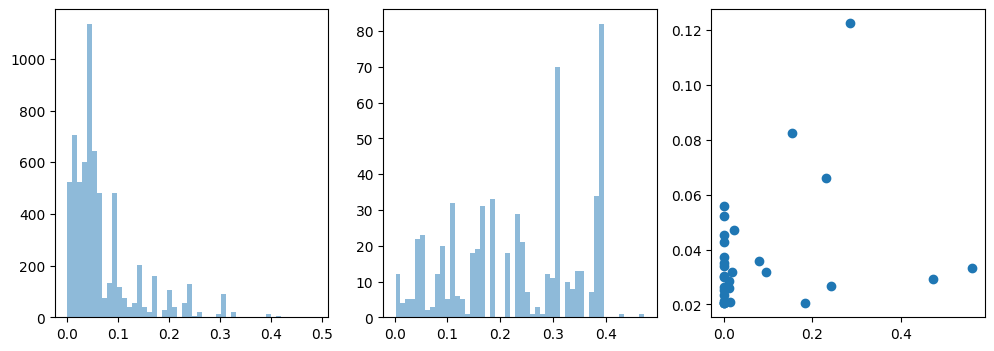

Average Survey Ratio: 0.037461436993466844
AUC = 0.87
tensor(0.0541) tensor([0]) tensor(0.)
tensor(0.5579) tensor([1]) tensor(-0.0442)
tensor(0.2195) tensor([0]) tensor(0.)
tensor(0.3162) tensor([0]) tensor(0.)
tensor(0.2265) tensor([0]) tensor(0.)
tensor(0.4160) tensor([0]) tensor(0.)
tensor(0.2152) tensor([0]) tensor(0.)
tensor(0.5531) tensor([0]) tensor(0.)
episode:  79 loss:  tensor(0.9035, device='cuda:0', grad_fn=<AddBackward0>) average reward:  -0.15355083
tensor(6.2078) tensor([1]) tensor(0.5208)
tensor(0.6259) tensor([0]) tensor(0.)
tensor(0.6733) tensor([0]) tensor(0.)
tensor(1.6896) tensor([0]) tensor(0.)
tensor(2.8997) tensor([0]) tensor(0.)
tensor(1.5599) tensor([0]) tensor(0.)
tensor(0.6180) tensor([0]) tensor(0.)
episode:  80 loss:  tensor(0.8410, device='cuda:0', grad_fn=<AddBackward0>) average reward:  -0.15502508
episode:  81 loss:  tensor(0.8200, device='cuda:0', grad_fn=<AddBackward0>) average reward:  -0.15641938
tensor(0.5306) tensor([0]) tensor(0.)
tensor(0.4803)

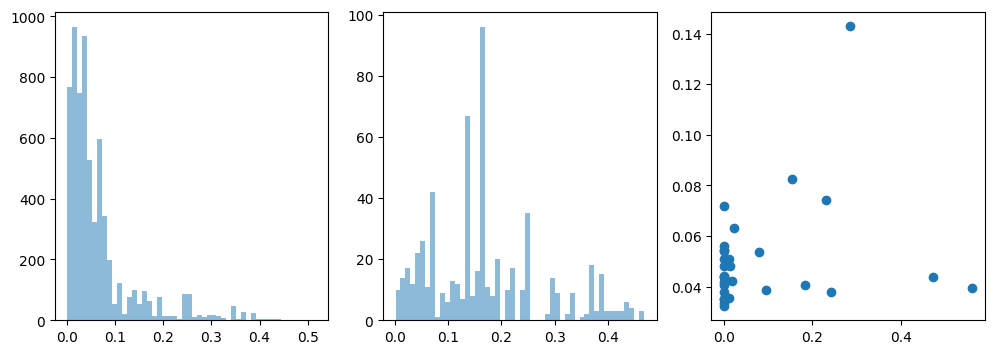

Average Survey Ratio: 0.05061872932609061
AUC = 0.82
tensor(0.5651) tensor([0]) tensor(0.)
tensor(1.8617) tensor([0]) tensor(0.)
tensor(1.4646) tensor([0]) tensor(0.)
tensor(0.4446) tensor([0]) tensor(0.)
tensor(0.2189) tensor([1]) tensor(-0.0781)
tensor(0.5378) tensor([0]) tensor(0.)
tensor(1.1656) tensor([0]) tensor(0.)
episode:  99 loss:  tensor(0.8458, device='cuda:0', grad_fn=<AddBackward0>) average reward:  -0.16504157
60 : 6 14 49 2 3
95 : 6 15 97 15 15
54 : 8 4 309 0 4
15 : 12 0 315 0 0
126 : 12 0 341 0 0
100 : 15 0 343 0 0
58 : 5 3 127 3 3
63 : 13 161 341 0 4
145 : 9 0 267 0 0
148 : 9 5 284 0 0
141 : 11 0 342 0 0
74 : 12 185 329 107 111
142 : 11 0 341 0 0
108 : 12 0 333 0 0
86 : 6 0 187 0 0
150 : 10 5 333 5 5
35 : 11 63 343 0 34
79 : 13 0 342 0 0
13 : 14 4 314 4 4
14 : 7 0 153 0 0
42 : 9 0 295 0 0
112 : 7 0 161 0 0
104 : 11 0 296 0 0
4 : 13 0 331 0 0
45 : 6 0 199 0 0
80 : 7 64 263 0 1
37 : 11 27 283 24 24
1 : 12 22 279 2 2
78 : 14 0 313 0 0
69 : 7 28 121 28 28


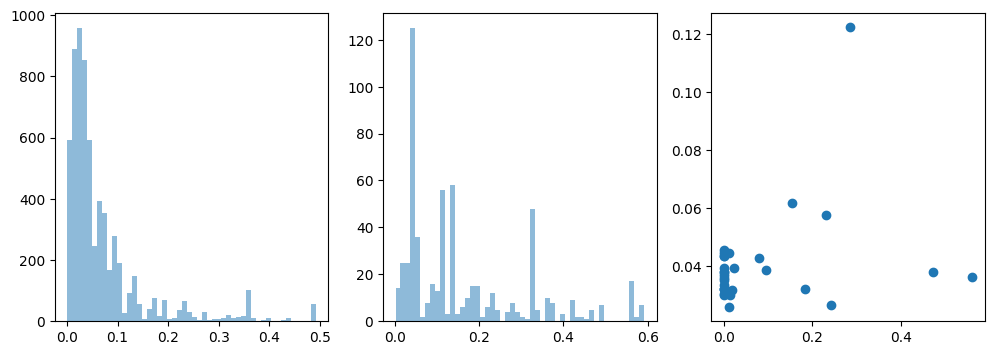

Average Survey Ratio: 0.040707353958148236
AUC = 0.75
60 : 49 14 49 6 9
95 : 97 15 97 10 15
54 : 309 4 309 0 4
15 : 315 0 315 0 0
126 : 341 0 341 0 0
100 : 343 0 343 0 0
58 : 127 3 127 3 3
63 : 341 161 341 6 19
145 : 267 0 267 0 0
148 : 284 5 284 5 5
141 : 342 0 342 0 0
74 : 329 185 329 1 7
142 : 341 0 341 0 0
108 : 333 0 333 0 0
86 : 187 0 187 0 0
150 : 333 5 333 4 5
35 : 343 63 343 7 20
79 : 342 0 342 0 0
13 : 314 4 314 4 4
14 : 153 0 153 0 0
42 : 295 0 295 0 0
112 : 161 0 161 0 0
104 : 296 0 296 0 0
4 : 331 0 331 0 0
45 : 199 0 199 0 0
80 : 263 64 263 1 8
37 : 283 27 283 14 15
1 : 279 22 279 11 14
78 : 313 0 313 0 0
69 : 121 28 121 5 12


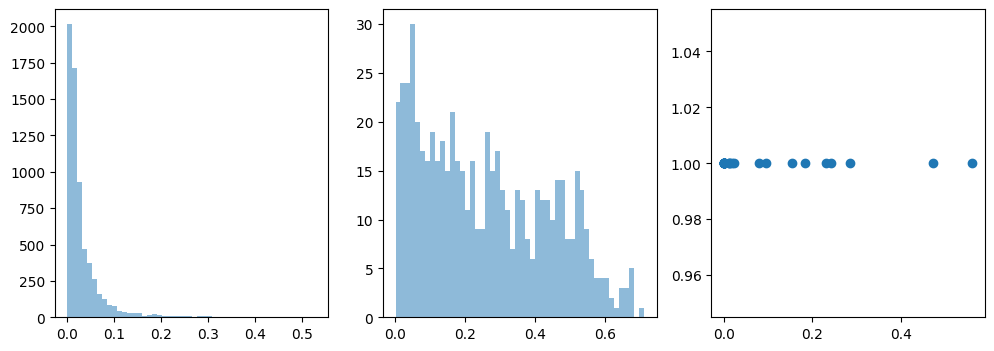

Average Survey Ratio: 1.0
AUC = 0.92
torch.Size([29840, 143]) torch.Size([7376, 143])
640 2093 7376
XgBoost: AUC = 0.82
Device set to : cuda:0
tensor(3.7796) tensor([1]) tensor(0.3780)
tensor(1.9148) tensor([1]) tensor(0.1915)
tensor(2.2090) tensor([1]) tensor(0.2209)
tensor(3.2278) tensor([1]) tensor(0.3228)
tensor(1.7453) tensor([1]) tensor(0.1745)
tensor(1.9584) tensor([1]) tensor(0.1958)
tensor(3.5230) tensor([1]) tensor(0.3523)
tensor(1.2487) tensor([1]) tensor(0.1249)
tensor(2.8136) tensor([1]) tensor(0.2814)
tensor(2.2434) tensor([1]) tensor(0.2243)
tensor(3.6450) tensor([1]) tensor(0.3645)
tensor(1.6860) tensor([1]) tensor(0.1686)
tensor(2.1602) tensor([1]) tensor(0.2160)
tensor(1.3438) tensor([1]) tensor(0.1344)
tensor(1.5311) tensor([1]) tensor(0.1531)
tensor(1.8574) tensor([1]) tensor(0.1857)
tensor(2.6193) tensor([1]) tensor(0.2619)
tensor(0.8643) tensor([1]) tensor(0.0864)
tensor(2.5680) tensor([1]) tensor(0.2568)
tensor(1.5911) tensor([1]) tensor(0.1591)
tensor(1.3211) te

tensor(1.0195) tensor([1]) tensor(0.1019)
tensor(0.2406) tensor([1]) tensor(0.0241)
tensor(0.6636) tensor([0]) tensor(0.)
tensor(0.2201) tensor([1]) tensor(0.0220)
tensor(0.3463) tensor([0]) tensor(0.)
tensor(1.3912) tensor([0]) tensor(0.)
tensor(0.5188) tensor([0]) tensor(0.)
tensor(0.8047) tensor([0]) tensor(0.)
tensor(0.8256) tensor([1]) tensor(0.0826)
tensor(0.5296) tensor([0]) tensor(0.)
tensor(0.8493) tensor([1]) tensor(0.0849)
tensor(0.2858) tensor([0]) tensor(0.)
tensor(0.1065) tensor([0]) tensor(0.)
tensor(0.2541) tensor([0]) tensor(0.)
tensor(0.7822) tensor([0]) tensor(0.)
tensor(0.6559) tensor([1]) tensor(0.0656)
tensor(0.5861) tensor([0]) tensor(0.)
tensor(0.6169) tensor([1]) tensor(0.0617)
tensor(0.5409) tensor([0]) tensor(0.)
tensor(0.5732) tensor([1]) tensor(0.0573)
tensor(0.5263) tensor([0]) tensor(0.)
tensor(0.9503) tensor([0]) tensor(0.)
tensor(5.0550) tensor([0]) tensor(0.)
tensor(0.3311) tensor([0]) tensor(0.)
tensor(0.9754) tensor([0]) tensor(0.)
tensor(1.2543) ten

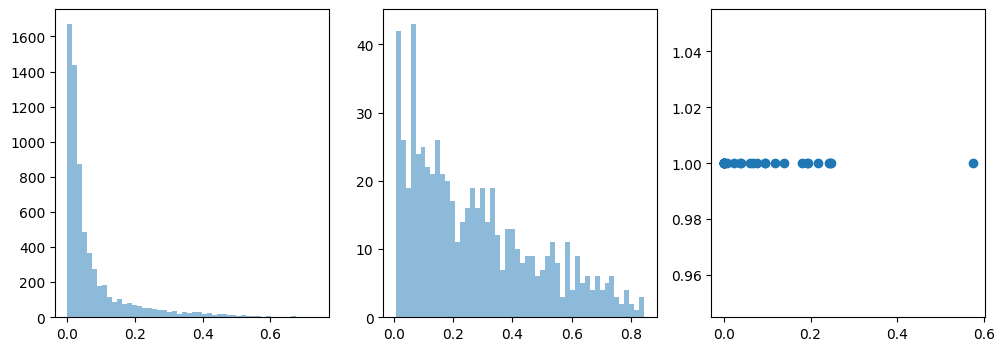

Average Survey Ratio: 1.0
AUC = 0.83
96 : 116 23 347 16 17
68 : 114 8 347 7 8
59 : 87 26 271 5 9
33 : 16 35 61 0 1
99 : 80 32 231 0 3
117 : 96 0 290 0 0
146 : 85 25 261 0 7
19 : 85 0 261 0 0
136 : 101 0 316 0 0
133 : 108 58 320 4 7
143 : 113 0 327 0 0
70 : 87 31 262 14 17
149 : 115 63 327 14 22
27 : 105 11 304 9 10
137 : 75 61 251 0 0
139 : 71 0 210 0 0
6 : 112 0 330 0 0
120 : 51 31 143 3 8
132 : 20 0 60 0 0
122 : 108 78 320 3 9
131 : 65 11 183 7 10
103 : 107 0 319 0 0
102 : 123 3 373 3 3
107 : 61 44 228 16 16
11 : 109 0 328 0 0
36 : 108 13 332 9 13
134 : 100 24 311 9 15
9 : 112 0 339 0 0
32 : 116 0 337 0 0
0 : 54 0 176 0 0
31 : 60 57 230 1 1


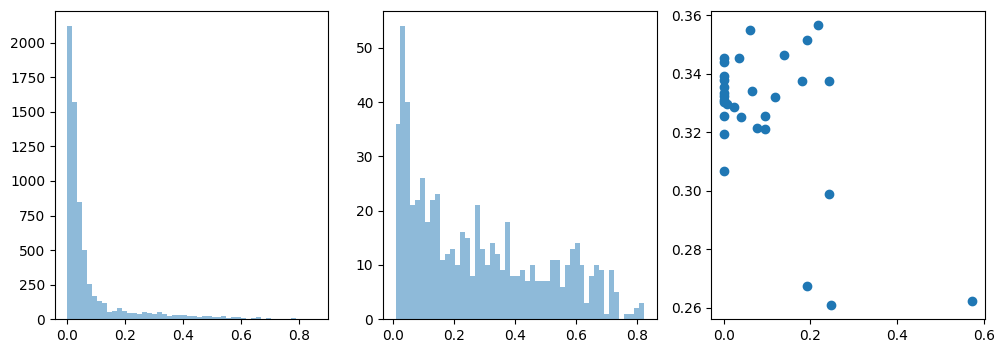

Average Survey Ratio: 0.32644536547370673
AUC = 0.82
96 : 31 23 347 15 19
68 : 31 8 347 4 8
59 : 23 26 271 3 8
33 : 12 35 61 0 4
99 : 22 32 231 0 0
117 : 28 0 290 0 0
146 : 28 25 261 2 7
19 : 23 0 261 0 0
136 : 26 0 316 0 0
133 : 30 58 320 0 7
143 : 32 0 327 0 0
70 : 28 31 262 11 22
149 : 30 63 327 20 25
27 : 31 11 304 4 6
137 : 27 61 251 0 0
139 : 19 0 210 0 0
6 : 27 0 330 0 0
120 : 10 31 143 0 18
132 : 13 0 60 0 0
122 : 34 78 320 5 14
131 : 18 11 183 7 8
103 : 27 0 319 0 0
102 : 35 3 373 3 3
107 : 23 44 228 8 19
11 : 36 0 328 0 0
36 : 31 13 332 10 13
134 : 30 24 311 10 16
9 : 34 0 339 0 0
32 : 26 0 337 0 0
0 : 20 0 176 0 0
31 : 25 57 230 1 5


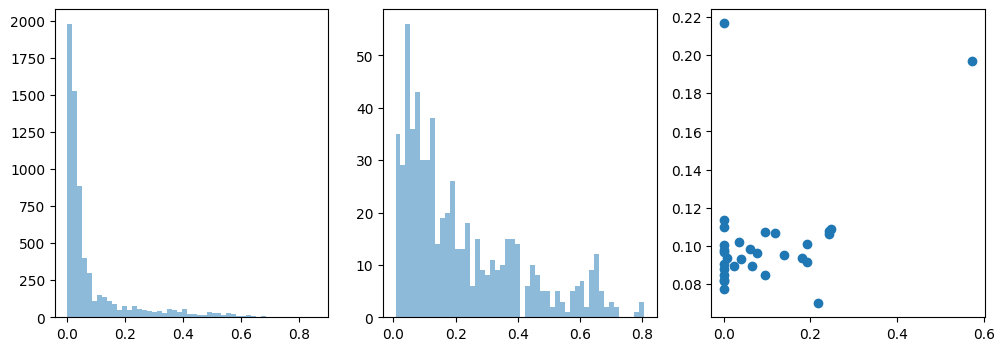

Average Survey Ratio: 0.10231375414346072
AUC = 0.79
tensor(0.2806) tensor([0]) tensor(0.)
tensor(0.1240) tensor([0]) tensor(0.)
tensor(0.8294) tensor([1]) tensor(-0.0171)
tensor(1.7370) tensor([0]) tensor(0.)
tensor(1.0724) tensor([1]) tensor(0.0072)
tensor(0.4674) tensor([1]) tensor(-0.0533)
tensor(0.4537) tensor([0]) tensor(0.)
tensor(1.0735) tensor([0]) tensor(0.)
tensor(0.3573) tensor([0]) tensor(0.)
tensor(0.9146) tensor([1]) tensor(-0.0085)
tensor(0.7072) tensor([1]) tensor(-0.0293)
tensor(0.3497) tensor([0]) tensor(0.)
tensor(0.2003) tensor([0]) tensor(0.)
tensor(0.4783) tensor([0]) tensor(0.)
tensor(0.0362) tensor([0]) tensor(0.)
tensor(0.0724) tensor([1]) tensor(-0.0928)
tensor(0.1931) tensor([0]) tensor(0.)
tensor(0.0240) tensor([0]) tensor(0.)
episode:  2 loss:  tensor(0.8110, device='cuda:0', grad_fn=<AddBackward0>) average reward:  -0.13855393
tensor(0.8215) tensor([0]) tensor(0.)
tensor(0.5262) tensor([0]) tensor(0.)
tensor(0.3994) tensor([1]) tensor(-0.0601)
tensor(1.47

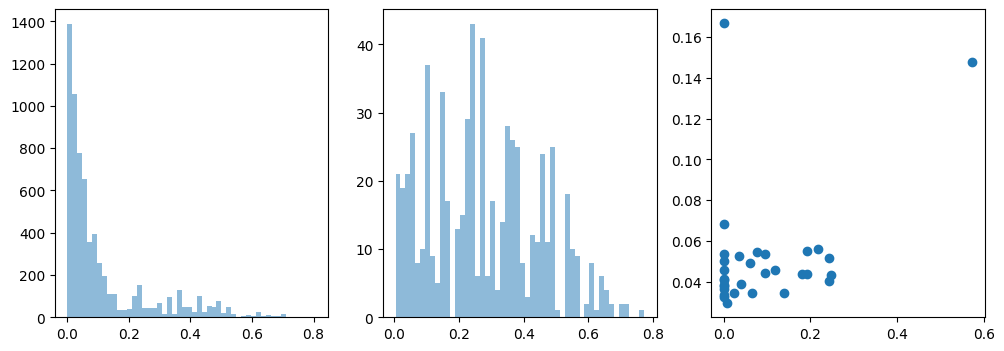

Average Survey Ratio: 0.05162536302443734
AUC = 0.79
tensor(1.6057) tensor([1]) tensor(0.0606)
tensor(0.7647) tensor([1]) tensor(-0.0235)
tensor(0.4367) tensor([0]) tensor(0.)
tensor(0.7883) tensor([0]) tensor(0.)
tensor(0.9955) tensor([0]) tensor(0.)
tensor(1.8499) tensor([0]) tensor(0.)
tensor(0.5253) tensor([0]) tensor(0.)
tensor(0.7642) tensor([0]) tensor(0.)
episode:  19 loss:  tensor(0.8512, device='cuda:0', grad_fn=<AddBackward0>) average reward:  -0.14736332
tensor(1.3750) tensor([0]) tensor(0.)
tensor(0.4370) tensor([0]) tensor(0.)
tensor(0.8225) tensor([0]) tensor(0.)
episode:  20 loss:  tensor(0.7873, device='cuda:0', grad_fn=<AddBackward0>) average reward:  -0.14619155
tensor(0.8552) tensor([0]) tensor(0.)
tensor(1.2611) tensor([0]) tensor(0.)
tensor(1.2435) tensor([0]) tensor(0.)
tensor(0.5094) tensor([0]) tensor(0.)
tensor(1.6253) tensor([0]) tensor(0.)
tensor(1.1411) tensor([0]) tensor(0.)
tensor(0.8483) tensor([0]) tensor(0.)
tensor(0.8631) tensor([0]) tensor(0.)
tensor

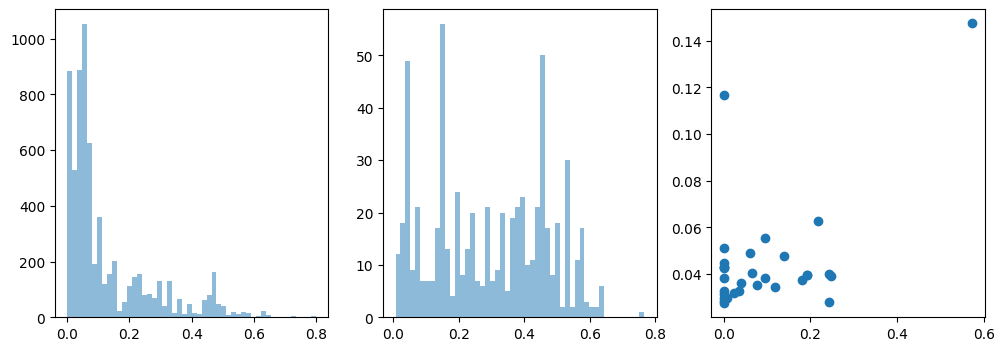

Average Survey Ratio: 0.0449519783518175
AUC = 0.78
tensor(0.4501) tensor([0]) tensor(0.)
tensor(0.1476) tensor([0]) tensor(0.)
episode:  39 loss:  tensor(0.7888, device='cuda:0', grad_fn=<AddBackward0>) average reward:  -0.13651499


KeyboardInterrupt: 

In [11]:
AUC_dict = {}
for j in range(6):
    dic = k_fold_test()
    if( j == 0 ):
        AUC_dict = dic
    else:
        for key in AUC_dict.keys():
            AUC_dict[key].extend(dic[key])
            
for key in AUC_dict.keys():
    print('key: ', key, 'mean: ', np.mean(AUC_dict[key]), 'median: ', np.median(AUC_dict[key]))

In [ ]:
k_fold_test(10)